## Importing data

title=Aluminium
alc1 mi=117 m=105 t=390 r=118 
alc2 mi=117 m=148 t=768 r=118
alc3 mi=117 m=189 t=1450 r=118

title=Aluminium Scratched
alsc1 mi=117 m=105 t=383 r=118
alsc2 mi=117 m=143 t=896 r=118
alsc3 mi=117 m=190 t=1593 r=118

title=Whole Rice
wc1 mi=75 m=115 t=410 r=136
wc2 mi=75 m=126 t=890 r=136
wc1 mi=75 m=151 t=1520 r=136

title=Assymetric Flame
asc1 mi=75 m=192 t=393 r=136
asc2 mi=75 m=236 t=840 r=136
asc3 mi=75 m=258 t=1635 r=136

title=First Mass/Area
h1c1 mi=50 m=80 t=241 r=136
h1c2 mi=50 m=126 t=751 r=136
h1c3 mi=50 m=165 t=1316 r=136

title=Second Mass/Area , High Flame
h2c1 mi=75 m=125 t=297 r=136
h2c2 mi=75 m=175 t=668 r=136
h2c3 mi=75 m=225 t=1230 r=136

title=Third Mass/Area
h3c1 mi=100 m=164 t=340 r=136
h3c2 mi=100 m=243 t=858 r=136
h3c3 mi=100 m=348 t=1501 r=136

title=Low Flame
f1c1 mi=75 m=144 t=681 r=136
f1c2 mi=75 m=239 t=1481 r=136
f1c3 mi=75 m=319 t=2743 r=136

title=Medium Flame
f2c1 mi=75 m=122 t=283 r=136
f2c2 mi=75 m=170 t=733 r=136
f2c3 mi=75 m=252 t=1569 r=136

Parsed metadata entries: 24
Loaded 23 images.


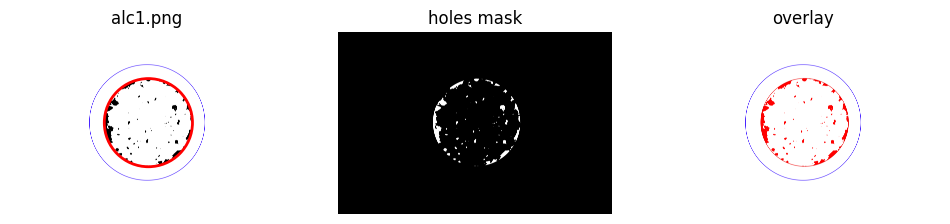

In [1]:
# Cell: load_images_and_metadata.ipynb

import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

# ================================================
#  1) PARSE TEXT METADATA
# ================================================

raw = """
title=Aluminium
alc1 mi=61 m=105 t=390 r=118 
alc2 mi=61 m=148 t=768 r=118
alc3 mi=61 m=189 t=1450 r=118

title=Whole Rice
wc1 mi=75 m=115 t=410 r=136
wc2 mi=75 m=126 t=890 r=136
wc3 mi=75 m=151 t=1520 r=136

title=Assymetric Flame
asc1 mi=75 m=192 t=393 r=136
asc2 mi=75 m=236 t=840 r=136
asc3 mi=75 m=258 t=1635 r=136

title=First Mass/Area
h1c1 mi=50 m=80 t=241 r=136
h1c2 mi=50 m=126 t=751 r=136
h1c3 mi=50 m=165 t=1316 r=136

title=Second Mass/Area
h2c1 mi=75 m=125 t=297 r=136
h2c2 mi=75 m=175 t=668 r=136
h2c3 mi=75 m=225 t=1230 r=136

title=Third Mass/Area
h3c1 mi=100 m=164 t=340 r=136
h3c2 mi=100 m=243 t=858 r=136
h3c3 mi=100 m=348 t=1501 r=136

title=Low Flame
f1c1 mi=75 m=144 t=681 r=136
f1c2 mi=75 m=239 t=1481 r=136
f1c3 mi=75 m=319 t=2743 r=136

title=Medium Flame
f2c1 mi=75 m=122 t=283 r=136
f2c2 mi=75 m=170 t=733 r=136
f2c3 mi=75 m=252 t=1569 r=136
"""

metadata = {}
current_title = None

for line in raw.splitlines():
    line = line.strip()
    if not line: continue

    if line.startswith("title="):
        current_title = line.split("=",1)[1].strip()
        continue

    m = re.match(r"(\S+)\s+mi=(\d+)\s+m=(\d+)\s+t=(\d+)\s+r=(\d+)", line)
    if m:
        name, mi, m_final, t, r = m.groups()
        mi = int(mi); m_final = int(m_final); t = int(t); r = int(r)

        # Defaults
        pot = "Cast Iron Pot"
        flame = "High"

        if "Aluminium" in current_title:
            pot = "Aluminium Pot"
        if "Low Flame" in current_title:
            flame = "Low"
        if "Medium Flame" in current_title:
            flame = "Medium"

        cook_index = re.search(r'c(\d+)', name)
        cook = int(cook_index.group(1)) if cook_index else None

        metadata[name.lower()] = {
            "config": name,
            "series": current_title,
            "mi": mi,
            "m": m_final,
            "t": t,
            "r": r,
            "cook": cook,
            "pot": pot,
            "flame": flame
        }

print("Parsed metadata entries:", len(metadata))


# ================================================
#  2) IMAGE LOADING WITH RED RING REMOVAL
# ================================================

def load_and_process_images(folder='.', pattern='*.png', show_example=True):
    fnames = sorted(glob.glob(os.path.join(folder, pattern)))
    results = []

    if len(fnames) == 0:
        print("No PNG images found.")
        return results

    for fname in fnames:
        key = os.path.splitext(os.path.basename(fname))[0].lower()

        img_bgr = cv2.imdecode(np.fromfile(fname, dtype=np.uint8), cv2.IMREAD_COLOR)
        if img_bgr is None:
            img_bgr = cv2.imread(fname)

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        h, w = gray.shape

        # --- Detect red circle ---
        hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0,60,40]); upper1 = np.array([10,255,255])
        lower2 = np.array([160,60,40]); upper2 = np.array([179,255,255])
        red_mask = cv2.bitwise_or(cv2.inRange(hsv, lower1, upper1),
                                  cv2.inRange(hsv, lower2, upper2))
        kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kern,2)

        cnts,_ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        center, radius = None, None
        if cnts:
            c = max(cnts, key=cv2.contourArea)
            (x,y),r = cv2.minEnclosingCircle(c)
            center, radius = (x,y), r

        # --- Build hole mask ---
        holes_mask = np.zeros_like(gray, np.uint8)

        if center:
            cx,cy = int(center[0]), int(center[1])
            R = int(radius)
            Y,X = np.ogrid[:h,:w]
            roi = (X-cx)**2 + (Y-cy)**2 <= R*R

            # 1) Remove red ring pixels BEFORE thresholding
            gray_clean = gray.copy()
            gray_clean[red_mask > 0] = 255  # bright → never hole

            # 2) Local threshold inside ROI
            img_roi = gray_clean.copy()
            img_roi[~roi] = 255
            _,bw = cv2.threshold(img_roi,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

            # 3) Holes = dark regions
            holes_mask = (bw==0).astype(np.uint8)

            # 4) Morphology cleanup
            kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
            holes_mask = cv2.morphologyEx(holes_mask, cv2.MORPH_OPEN, kernel2, iterations=1)
            holes_mask = cv2.morphologyEx(holes_mask, cv2.MORPH_CLOSE, kernel2, iterations=1)

            holes_mask = holes_mask * roi

        results.append({
            "fname": os.path.basename(fname),
            "img_rgb": img_rgb,
            "img_gray": gray,
            "center": center,
            "radius": radius,
            "holes_mask": holes_mask.astype(np.uint8),
            "meta": metadata.get(key, None)
        })

    print(f"Loaded {len(results)} images.")

    if show_example:
        r0 = results[0]
        fig,axs=plt.subplots(1,3,figsize=(12,4))
        axs[0].imshow(r0["img_rgb"]); axs[0].set_title(r0["fname"]); axs[0].axis("off")
        circ = plt.Circle(r0["center"],r0["radius"],color="red",fill=False,linewidth=2)
        axs[0].add_patch(circ)
        axs[1].imshow(r0["holes_mask"],cmap='gray'); axs[1].set_title("holes mask"); axs[1].axis("off")
        overlay=r0["img_rgb"].copy()
        overlay[r0["holes_mask"]>0]=[255,0,0]
        axs[2].imshow(overlay); axs[2].set_title("overlay"); axs[2].axis("off")
        plt.show()

    return results


# Ejecuta
results = load_and_process_images()


## KDE creation cell

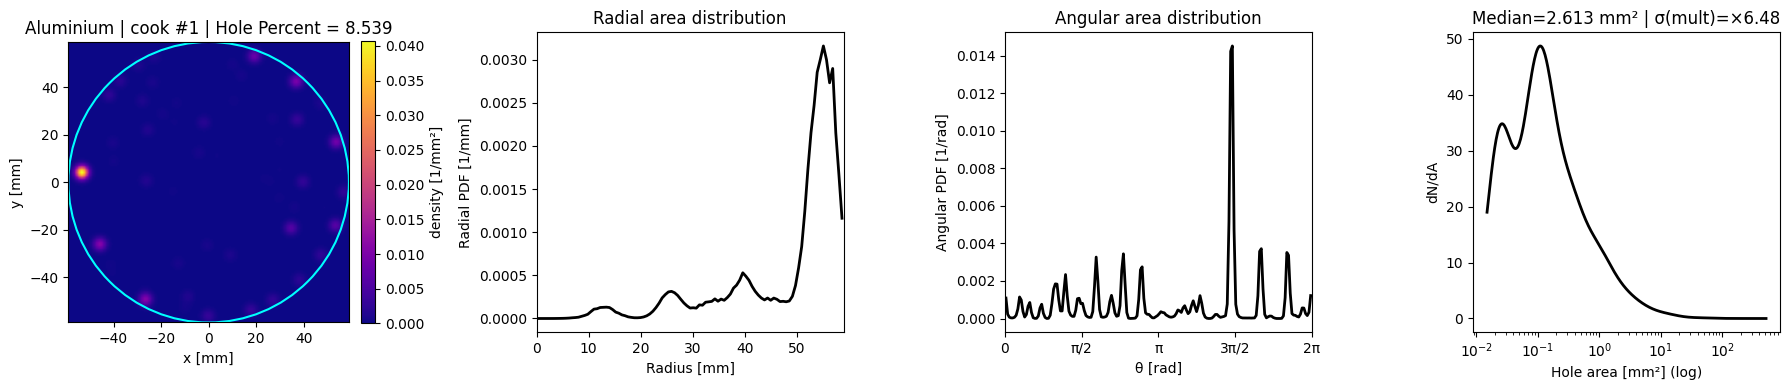

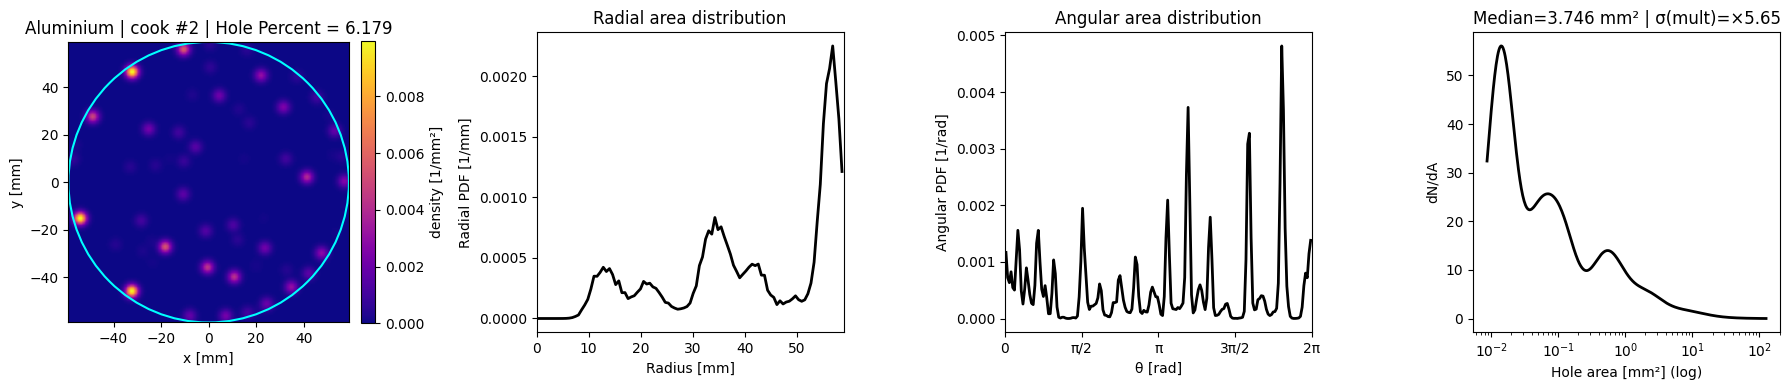

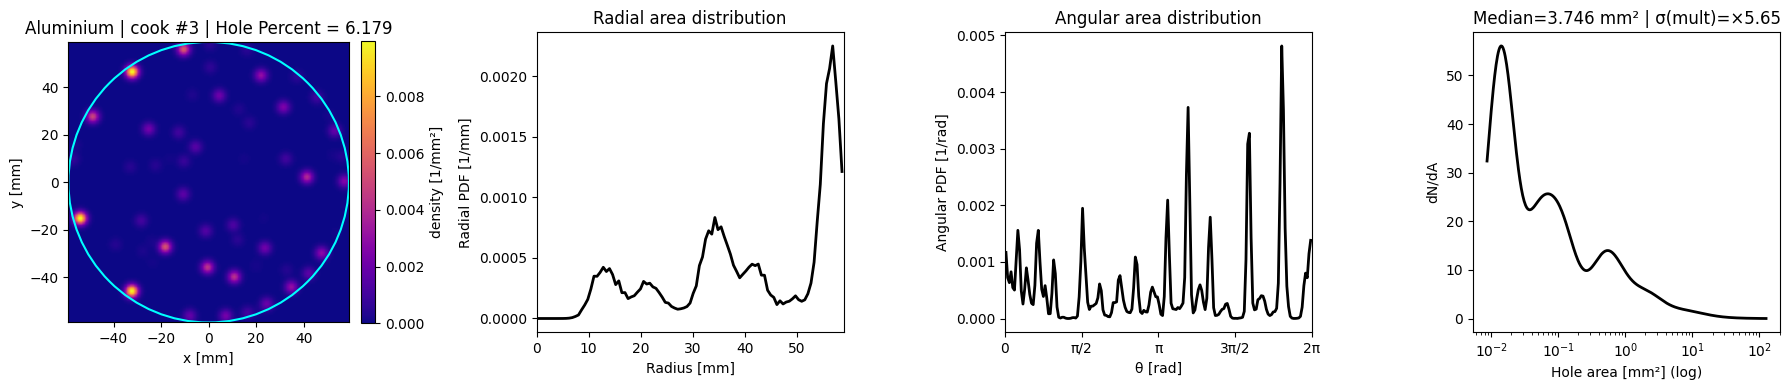

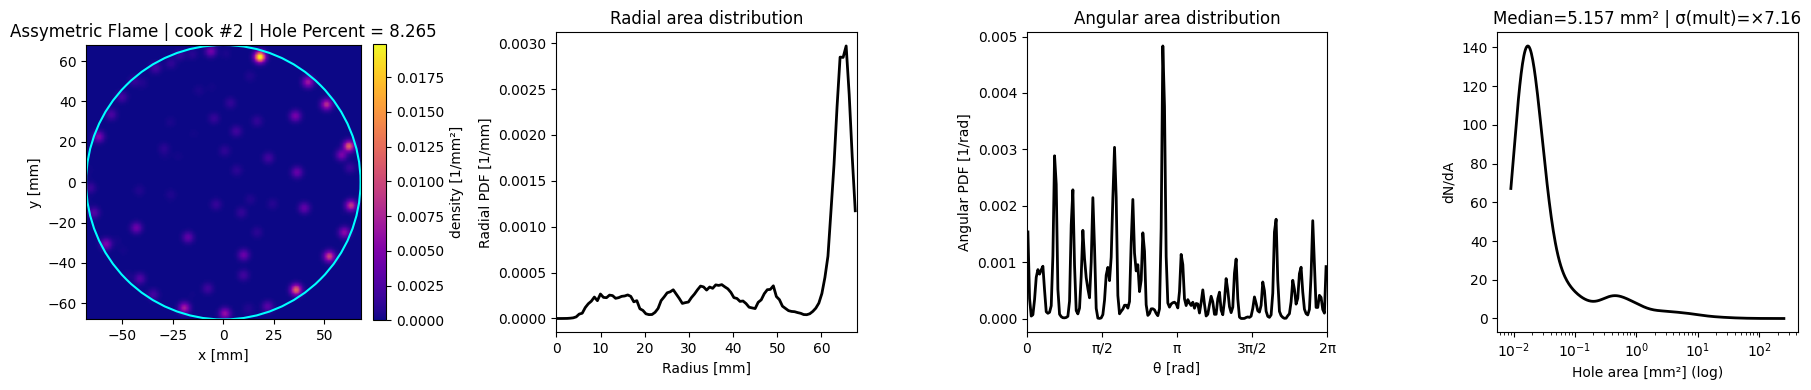

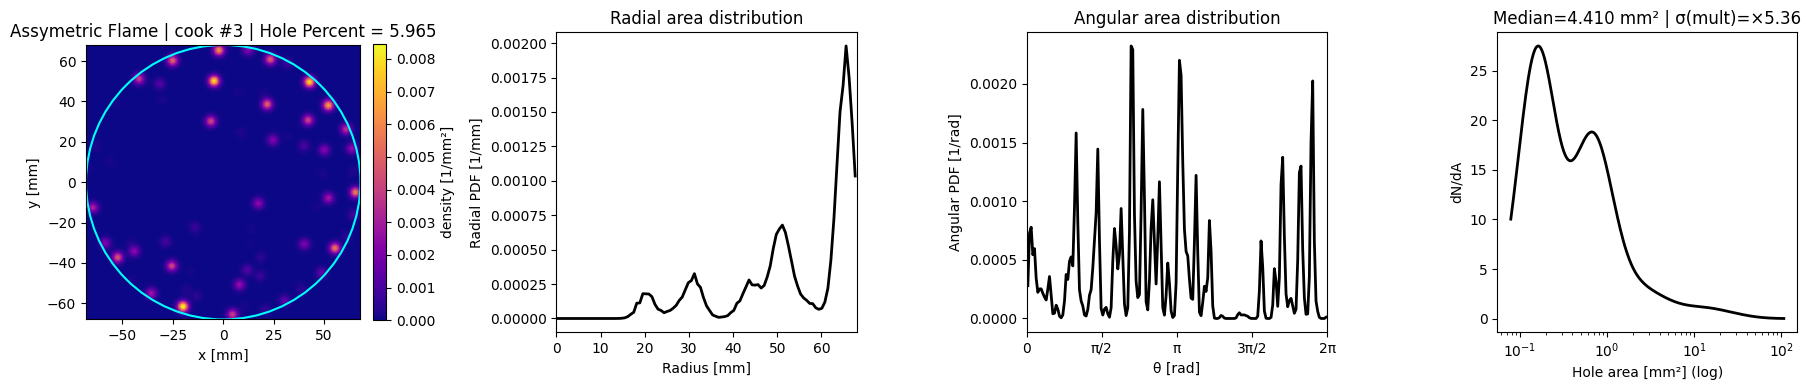

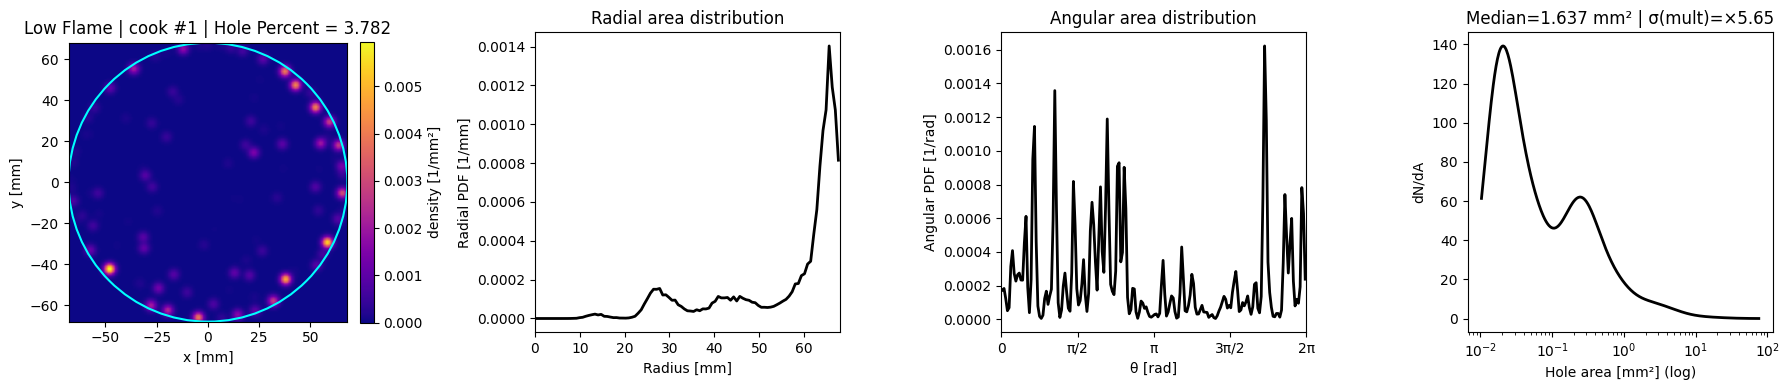

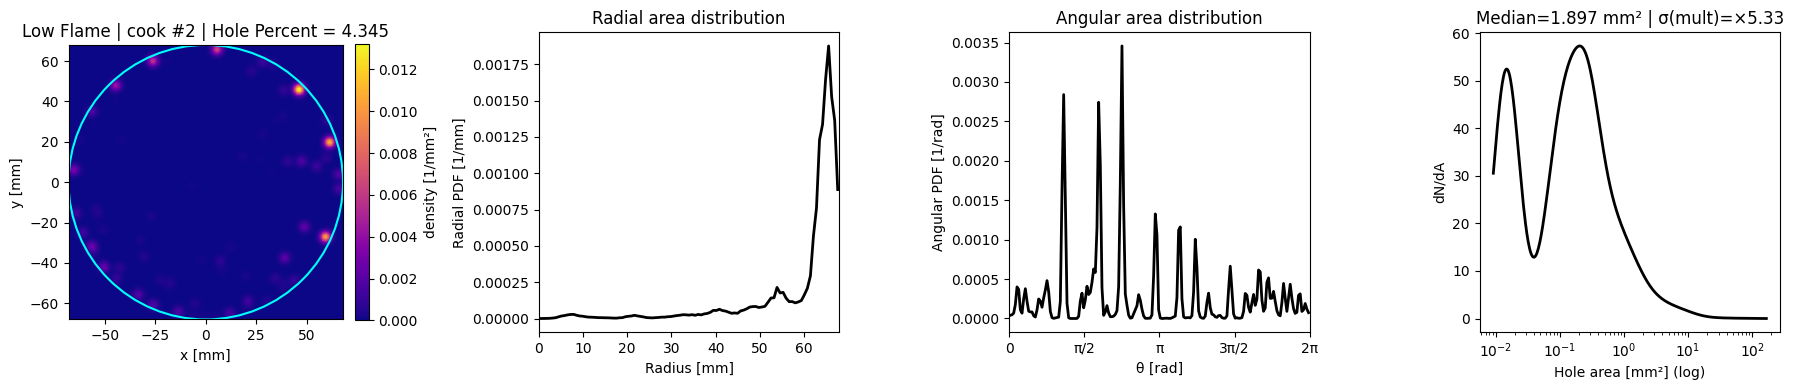

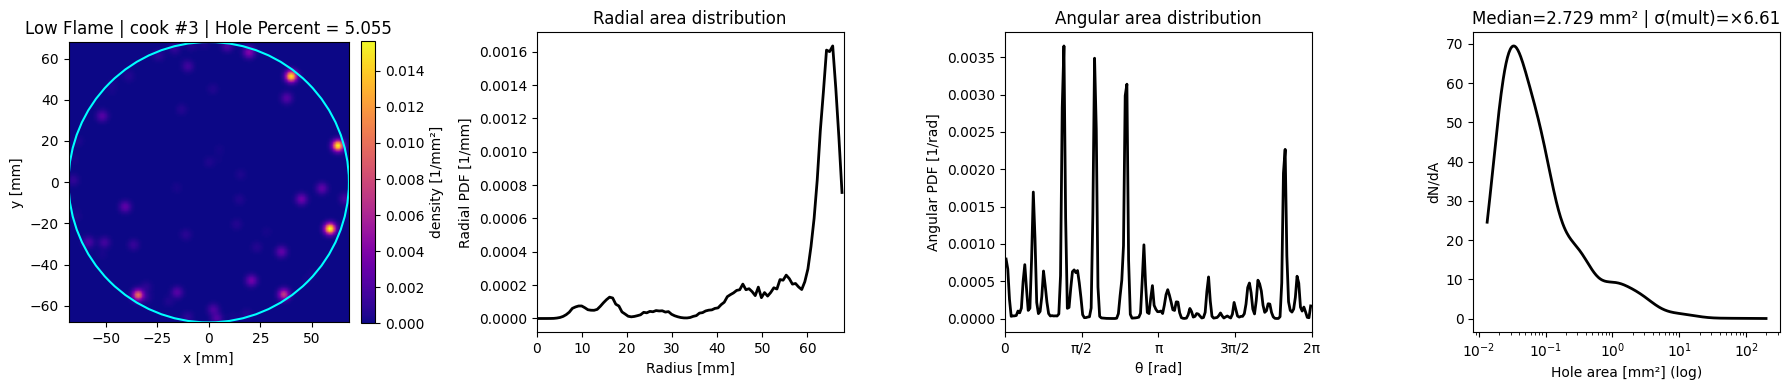

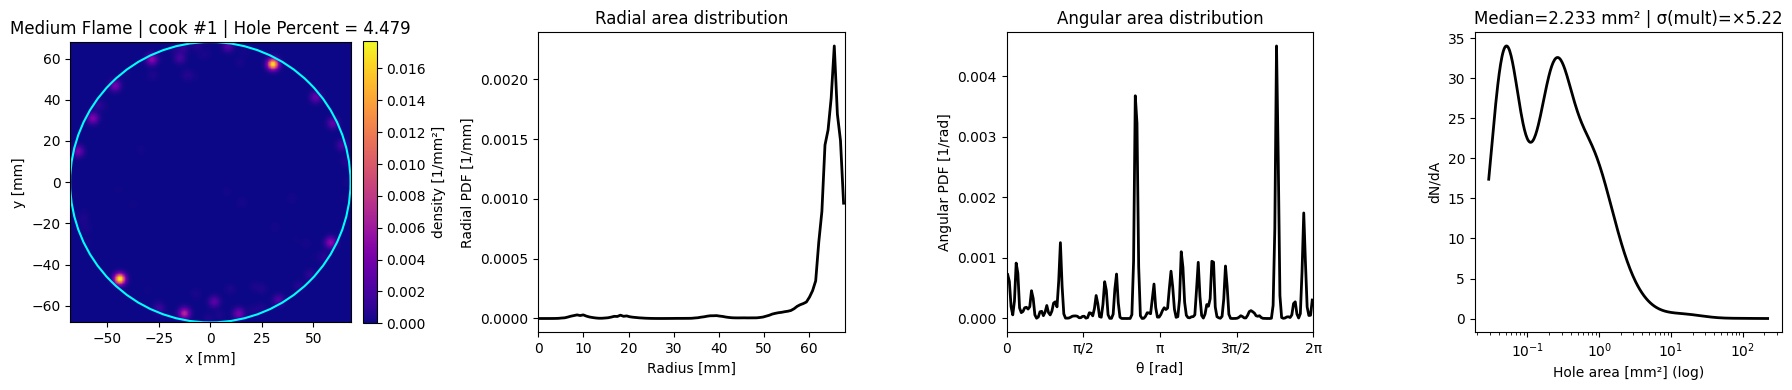

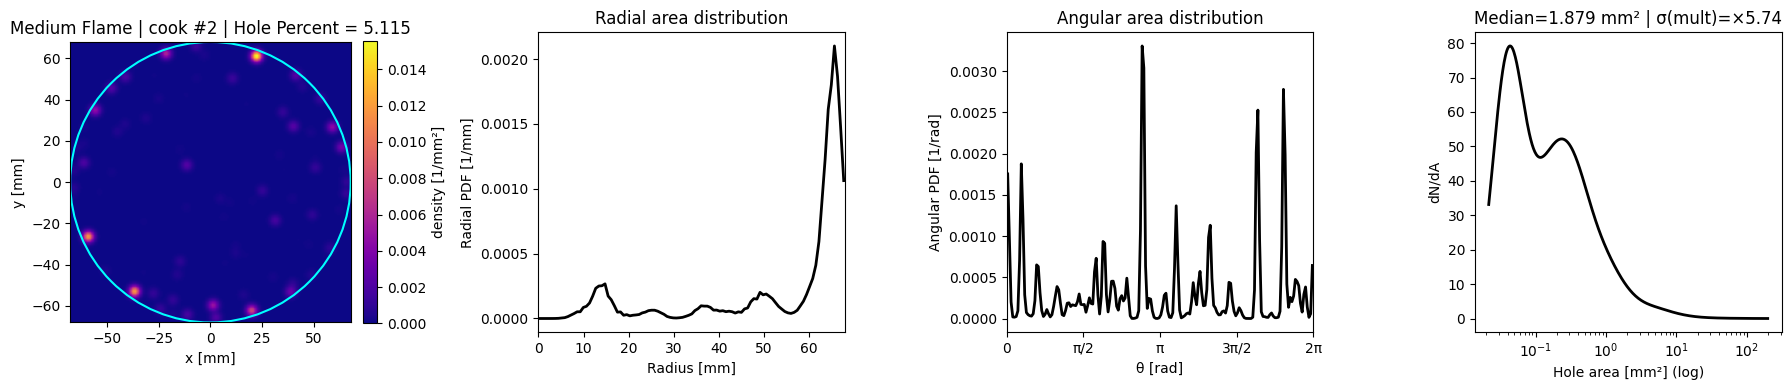

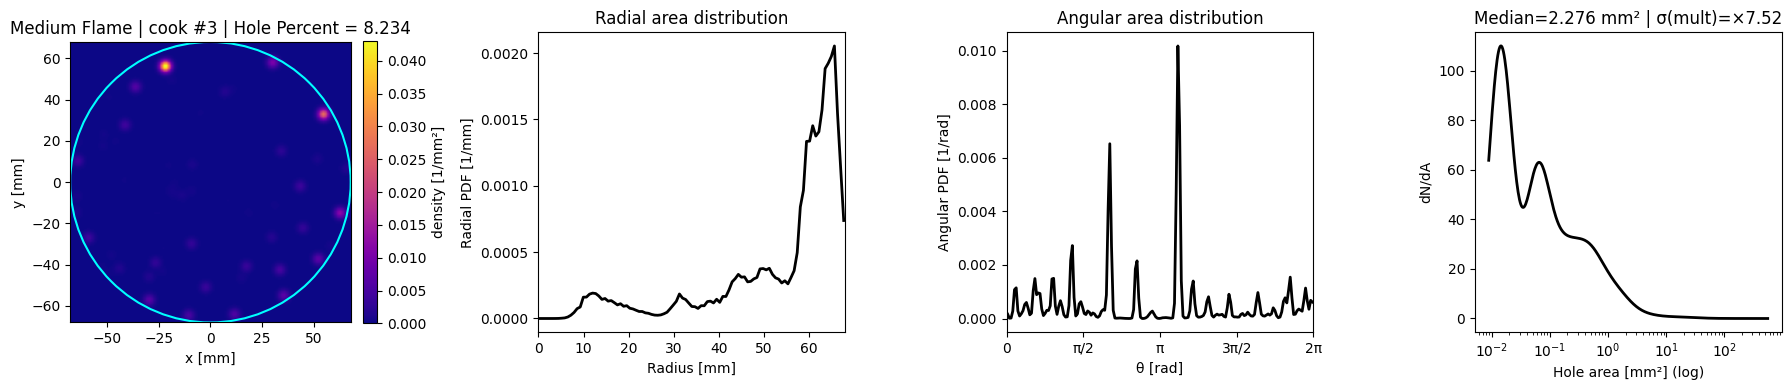

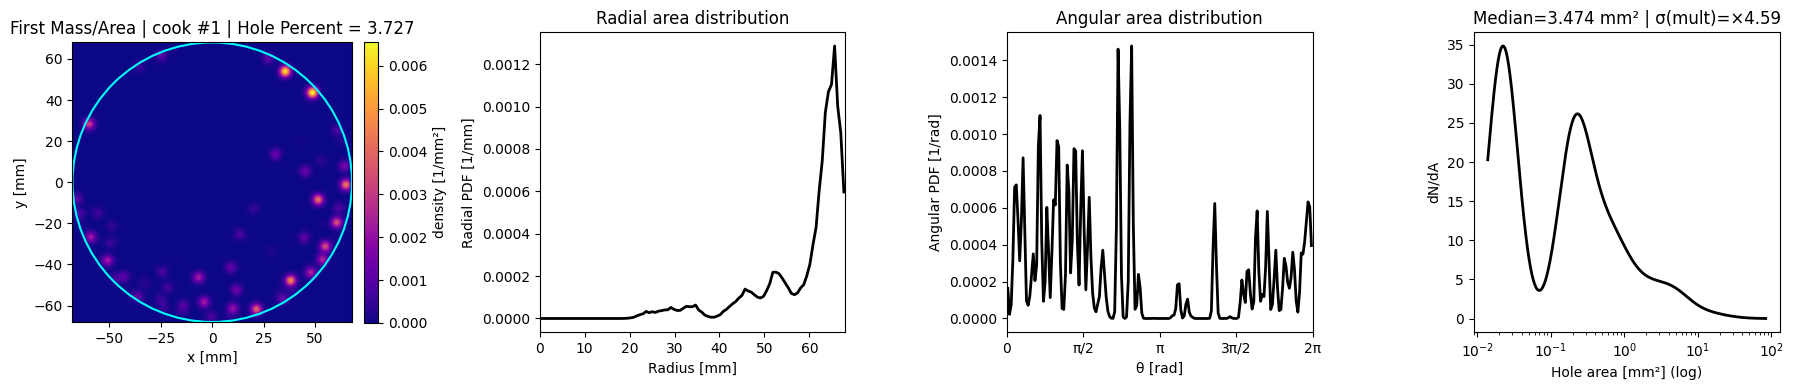

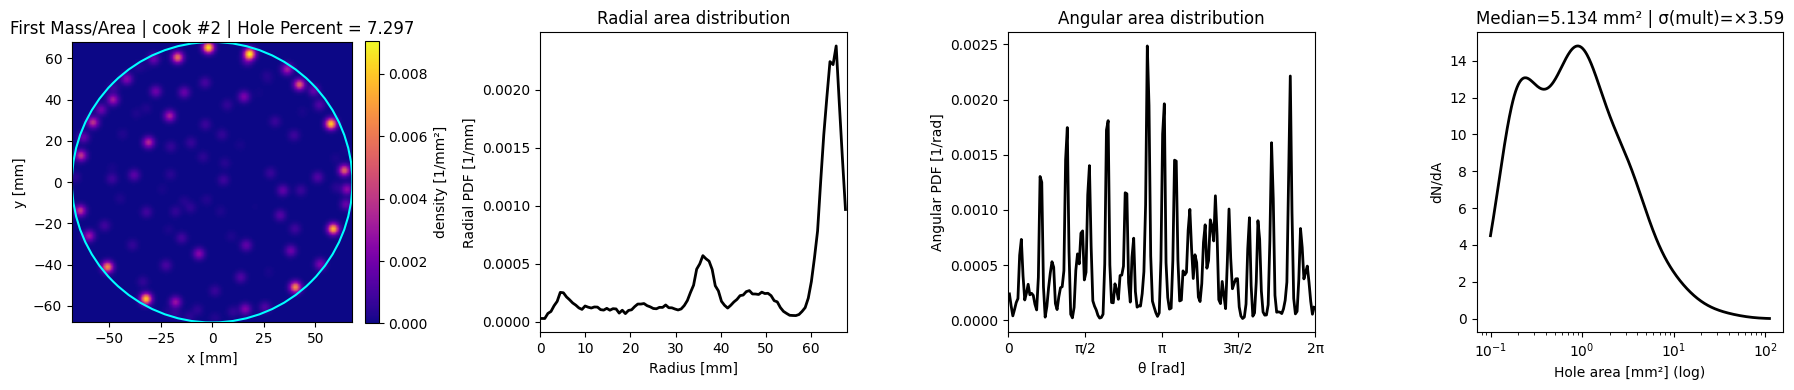

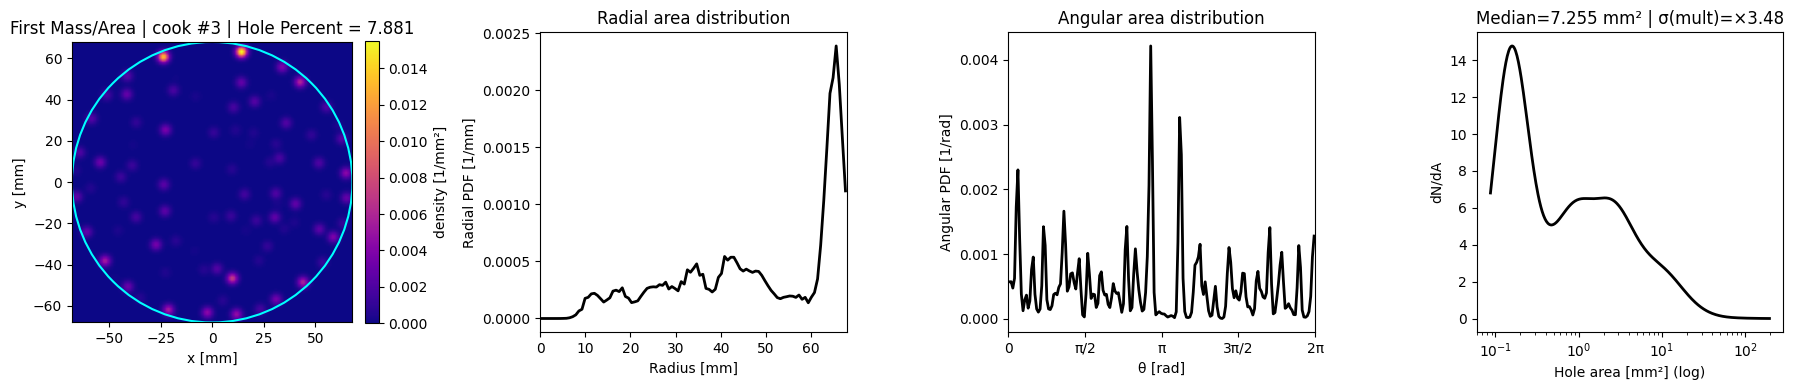

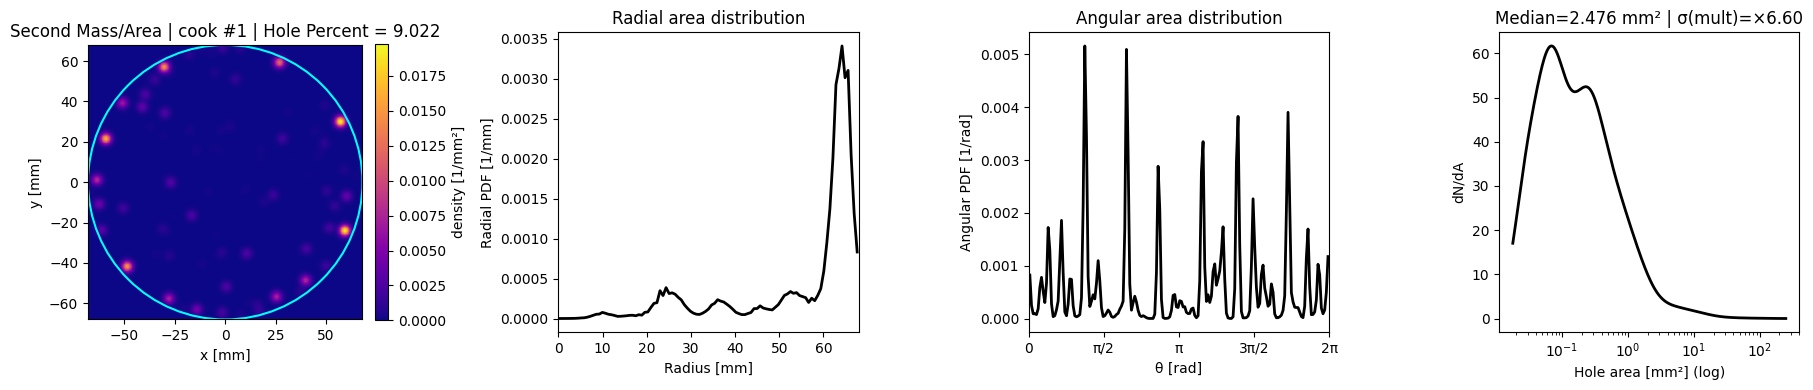

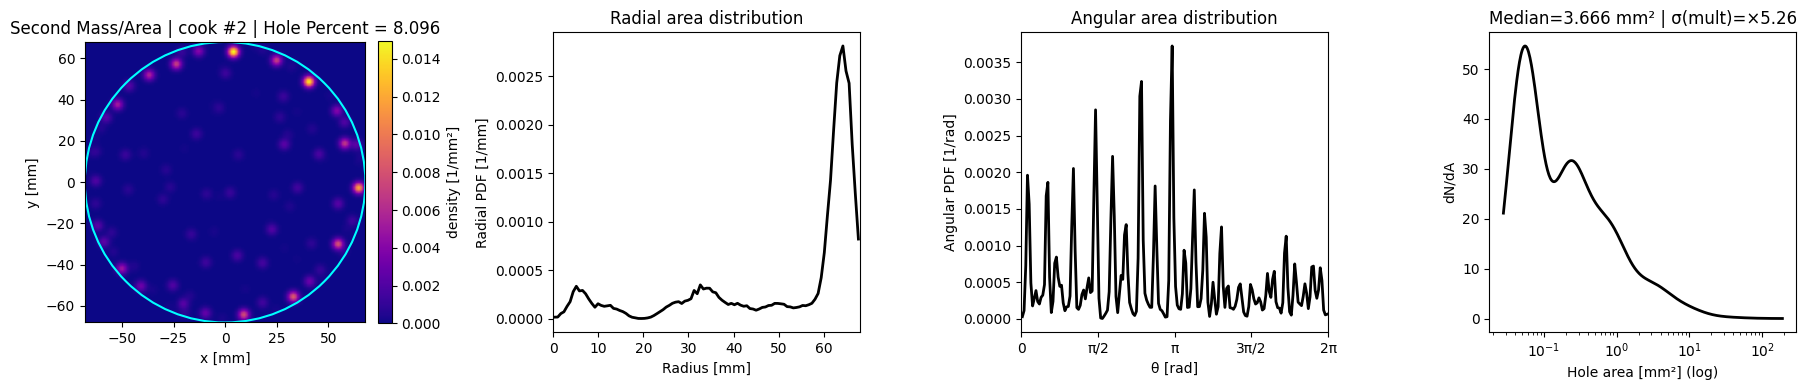

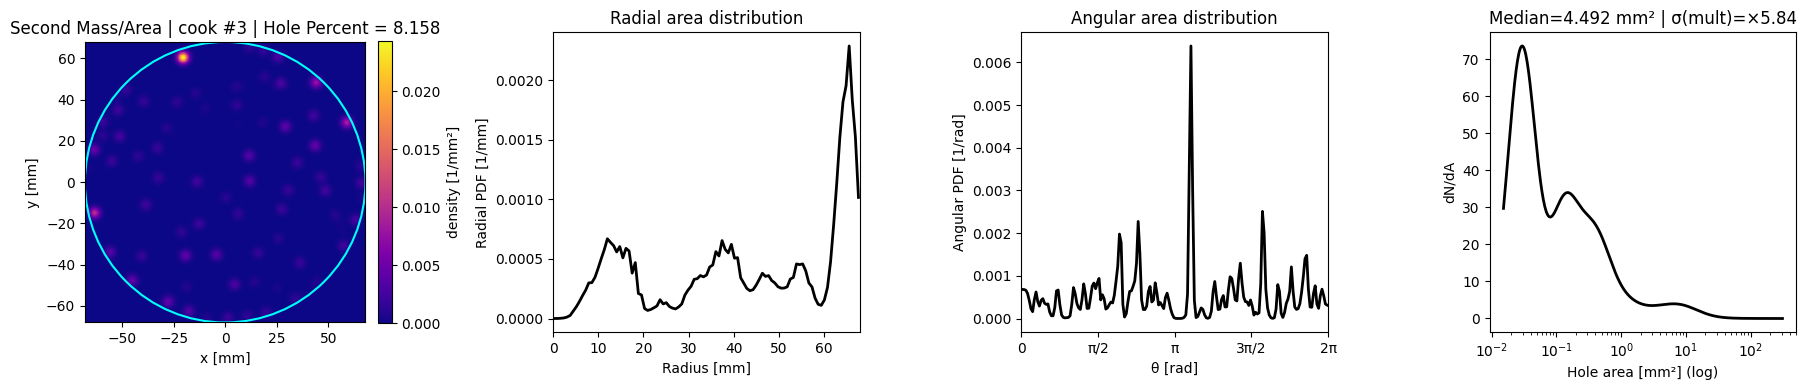

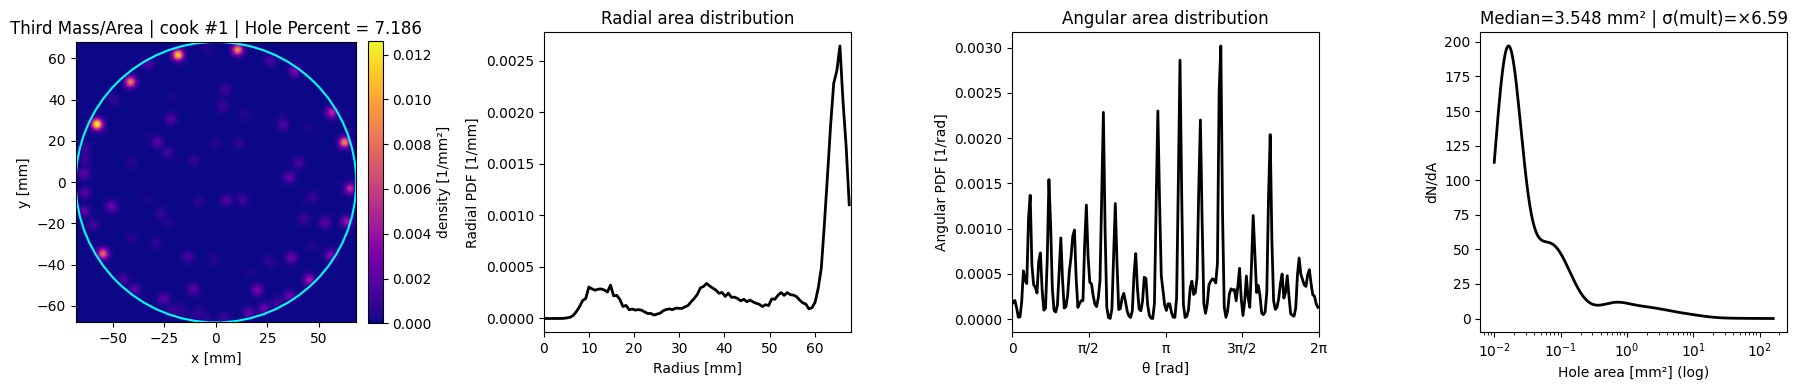

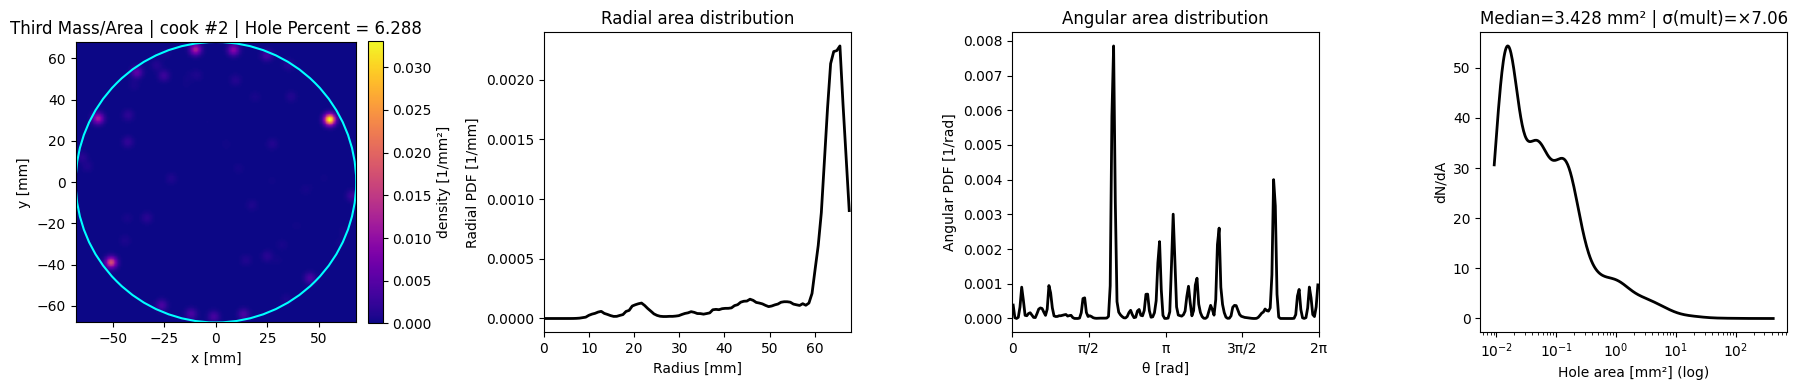

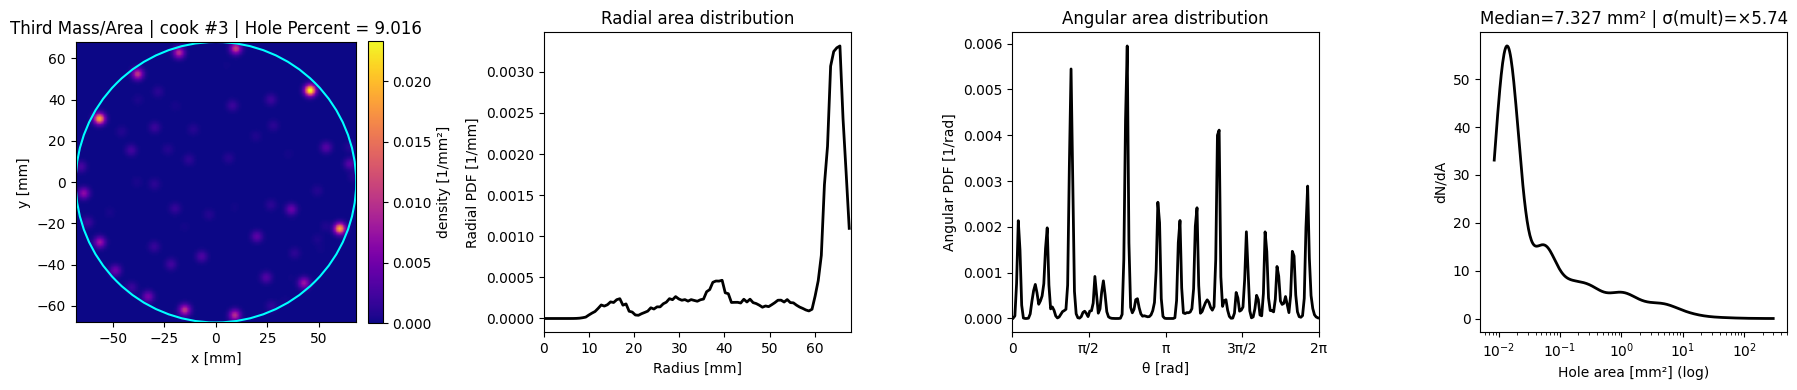

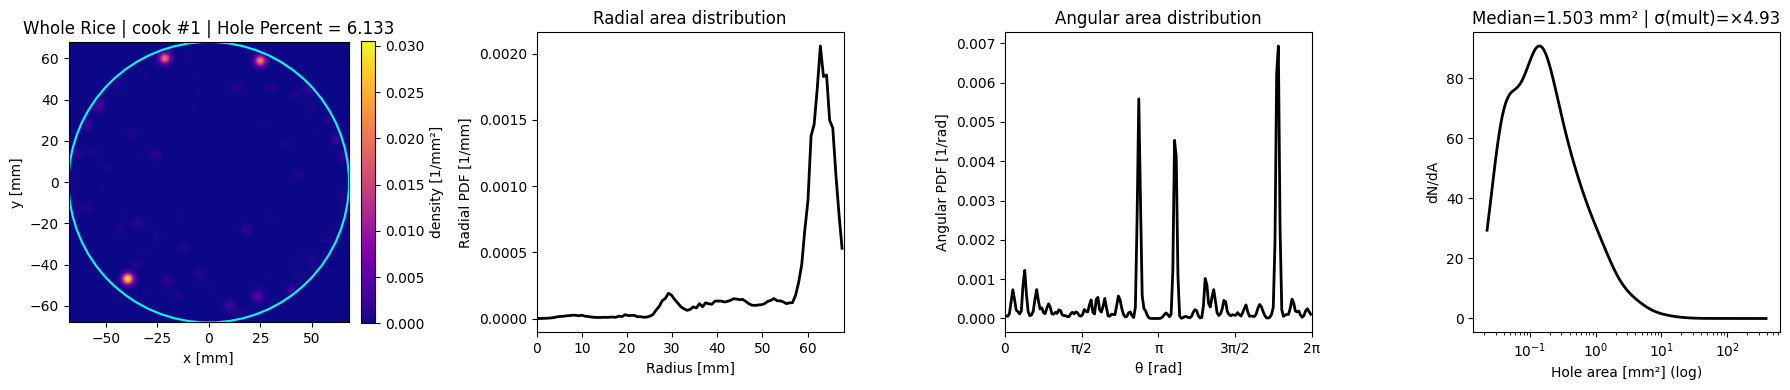

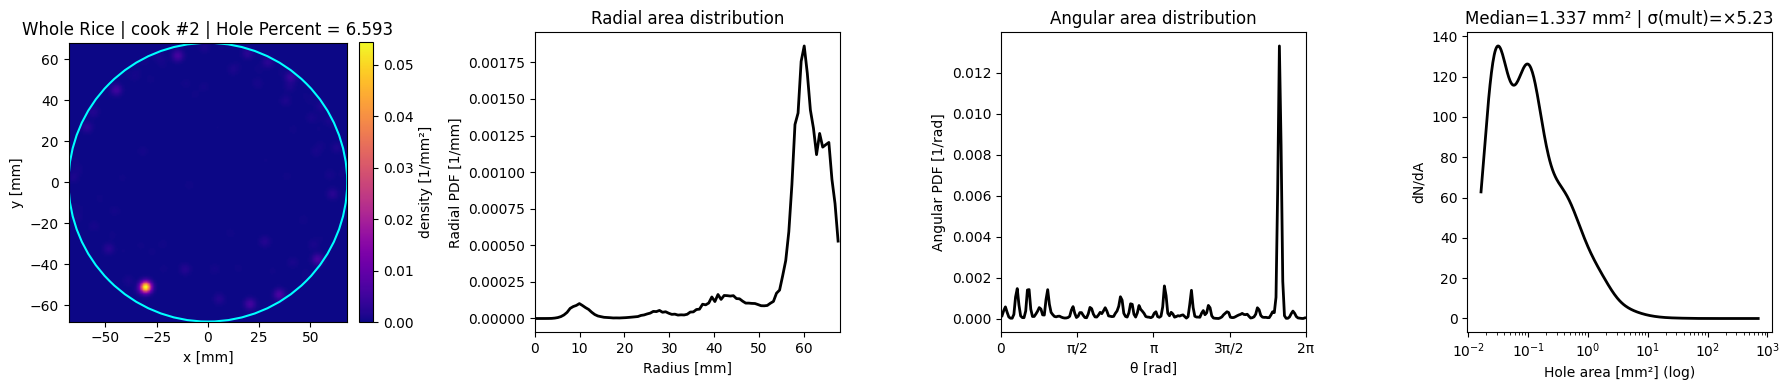

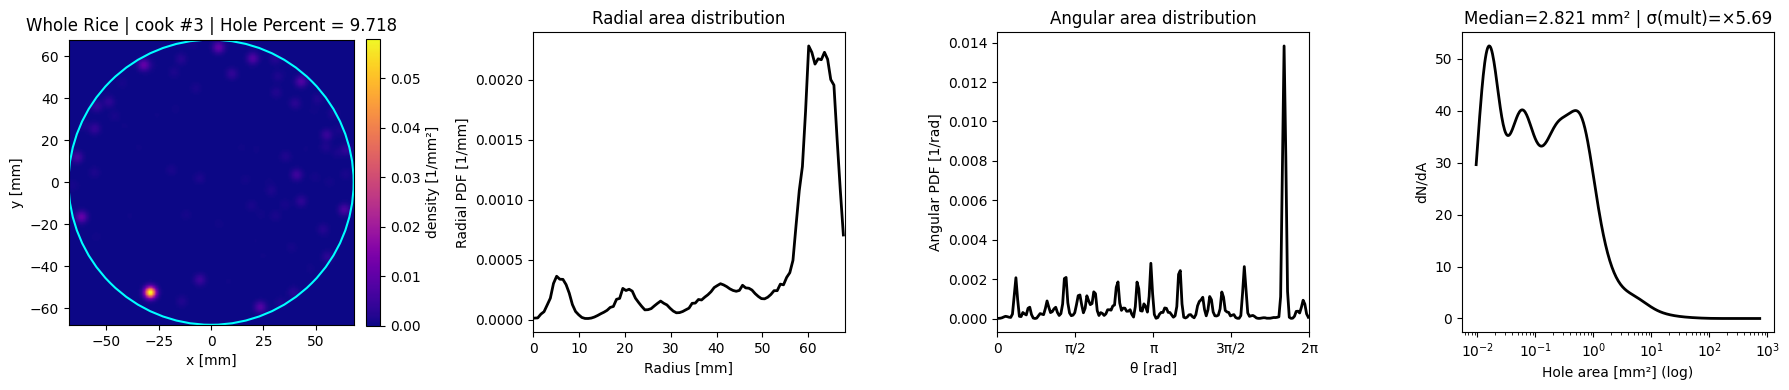

Computed KDEs for 23 images.


In [2]:
# Cell: compute_weighted_KDE_radial_angular.ipynb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import binned_statistic
import cv2

def analyze_image_density(result, bandwidth_mm=1.8, n_bins=200, n_theta=180, bandwidth_area=0.2):
    holes_mask = result['holes_mask']
    center = result['center']
    radius_px = result['radius']
    meta = result['meta']
    fname = result['fname']
    
    if meta is None or center is None:
        print(f"Skipping {fname} (missing metadata or circle)")
        return None

    # --- Spatial scaling ---
    R_mm = meta['r'] / 2.0
    scale = R_mm / radius_px

    h, w = holes_mask.shape
    cx, cy = center
    Y, X = np.indices((h, w))
    r_pix = np.sqrt((X-cx)**2 + (Y-cy)**2)
    roi = r_pix <= radius_px

    # --- Connected components (holes) ---
    num_lbl, labels, stats, centroids = cv2.connectedComponentsWithStats(
        holes_mask.astype(np.uint8), connectivity=8
    )
    areas_pix = stats[1:, cv2.CC_STAT_AREA]
    centroids = centroids[1:]

    if len(areas_pix) == 0:
        print("No holes in", fname)
        return None

    # Coordinates and sizes in mm
    Xc_mm = (centroids[:,0] - cx) * scale
    Yc_mm = (centroids[:,1] - cy) * scale
    areas_mm = areas_pix * (scale**2)

    # --- 2D KDE weighted by hole area ---
    coords = np.vstack([Xc_mm, Yc_mm]).T
    weights = areas_mm / areas_mm.sum()

    lim = R_mm
    grid_x, grid_y = np.linspace(-lim, lim, n_bins), np.linspace(-lim, lim, n_bins)
    gx, gy = np.meshgrid(grid_x, grid_y)
    sample_points = np.vstack([gx.ravel(), gy.ravel()]).T

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_mm)
    kde.fit(coords, sample_weight=weights)

    dens = np.exp(kde.score_samples(sample_points)).reshape(n_bins, n_bins)

    # --- Physical normalization ---
    area_black = areas_mm.sum()
    area_circle = np.pi * R_mm**2
    hole_prob = 100 * area_black / area_circle        # fraction of area burned

    dens = dens / dens.sum() * hole_prob        # total integral = hole_prob

    # --- Radial PDF (area-weighted) ---
    r_grid = np.sqrt(gx**2 + gy**2)
    mask = r_grid <= R_mm
    r_vals = r_grid[mask].ravel()
    dens_vals = dens[mask].ravel()

    # compute using area shell normalization
    r_bins = np.linspace(0, R_mm, 100)
    pdf_r_raw, edges, _ = binned_statistic(r_vals, dens_vals,
                                           statistic='sum', bins=r_bins)
    dr = r_bins[1] - r_bins[0]
    r_centers = 0.5*(edges[1:]+edges[:-1])

    # shell area = 2πr dr
    shell_area = 2*np.pi * r_centers * dr
    pdf_r = pdf_r_raw / shell_area   # units: 1/mm

    # ensure normalization
    # print(np.trapz(pdf_r * 2*np.pi*r_centers, r_centers))

    # --- Angular PDF (area-weighted) ---
    theta = np.arctan2(gy, gx)
    theta = (theta + np.pi/2) % (2*np.pi)
    θ_vals = theta[mask].ravel()

    pdf_theta_raw, θ_edges, _ = binned_statistic(θ_vals, dens_vals,
                                                 statistic='sum', bins=n_theta)
    dθ = θ_edges[1] - θ_edges[0]
    θ_centers = 0.5*(θ_edges[1:]+θ_edges[:-1])

    # wedge area = ∫ r dr dθ = 1/2 R^2 dθ
    wedge_area = 0.5 * (R_mm**2) * dθ
    pdf_theta = pdf_theta_raw / wedge_area     # units: 1/rad

    # --- Hole size log-KDE ---
    x = np.log10(areas_mm)
    mu = x.mean()
    sigma = x.std()

    kdeA = KernelDensity(kernel='gaussian', bandwidth=bandwidth_area)
    kdeA.fit(x.reshape(-1,1))

    xs = np.linspace(x.min()-0.3, x.max()+0.3, 400)
    logpdf = kdeA.score_samples(xs.reshape(-1,1))

    px = np.exp(logpdf) * len(areas_mm)
    A = 10**xs
    dNdA = px / (A * np.log(10))

    # --- Plotting (4 panels) ---
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,4))

    # KDE heatmap
    im = ax1.imshow(dens, extent=[-R_mm, R_mm, -R_mm, R_mm],
                    origin='lower', cmap='plasma')
    circ = plt.Circle((0,0), R_mm, edgecolor='cyan', fill=False, lw=1.5)
    ax1.add_patch(circ)
    ax1.set_aspect('equal')
    ax1.set_xlabel("x [mm]")
    ax1.set_ylabel("y [mm]")
    ax1.set_title(
        f"{meta['series']} | cook #{meta['cook']} | Hole Percent = {hole_prob:.3f}"
    )
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, label="density [1/mm²]")

    # Radial
    ax2.plot(r_centers, pdf_r, 'k-', lw=2)
    ax2.set_xlim(0, R_mm)
    ax2.set_xlabel("Radius [mm]")
    ax2.set_ylabel("Radial PDF [1/mm]")
    ax2.set_title("Radial area distribution")

    # Angular
    ax3.plot(θ_centers, pdf_theta, 'k-', lw=2)
    ax3.set_xlim(0, 2*np.pi)
    ax3.set_xlabel("θ [rad]")
    ax3.set_ylabel("Angular PDF [1/rad]")
    ax3.set_xticks(np.pi*np.array([0,0.5,1,1.5,2]))
    ax3.set_xticklabels(["0", "π/2", "π", "3π/2", "2π"])
    ax3.set_title("Angular area distribution")

    # Hole size
    ax4.plot(A, dNdA, 'k-', lw=2)
    ax4.set_xscale("log")
    ax4.set_xlabel("Hole area [mm²] (log)")
    ax4.set_ylabel("dN/dA")
    ax4.set_title(
        f"Median={10**mu:.3f} mm² | σ(mult)=×{10**sigma:.2f}"
    )

    plt.tight_layout()
    plt.show()

    return {
        "dens2D": dens,
        "r_mm": r_centers,
        "pdf_r": pdf_r,
        "theta": θ_centers,
        "pdf_theta": pdf_theta,
        "R_mm": R_mm,
        "hole_probability": hole_prob,
        "areas_mm": areas_mm,
        "meta": meta,
        "fname": fname
    }

# === Execute for all images ===
results_kde = []
for res in results:
    out = analyze_image_density(res, bandwidth_mm=1.8)
    if out is not None:
        results_kde.append(out)

print(f"Computed KDEs for {len(results_kde)} images.")

## Median Hole Size

Total configurations analyzed: 23
Total holes counted: 2067
Median hole area: 3.291 mm²
Mean hole area:   10.548 mm² ± 22.817 mm²


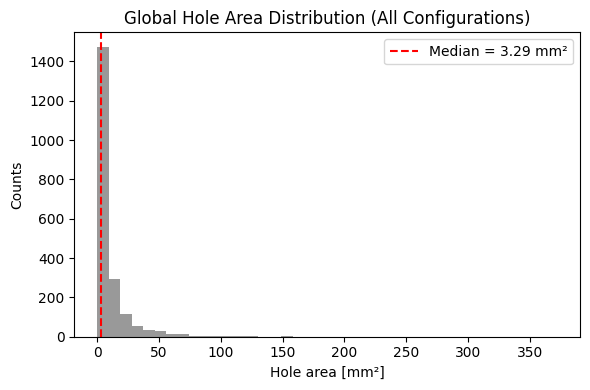

1.0249012754438884
1.85411616971131


In [3]:
# Cell: compute_global_median_hole_size.ipynb

import numpy as np

# Asegúrate de que results_kde existe (generado por analyze_image_density)
if "results_kde" not in locals():
    raise RuntimeError("results_kde not found. Run the KDE analysis cell first.")

# --- Collect all hole areas from all configurations ---
all_areas = []
for r in results_kde:
    if "areas_mm" in r and len(r["areas_mm"]) > 0:
        all_areas.extend(r["areas_mm"])

all_areas = np.array(all_areas)

# --- Compute global statistics ---
median_area = np.median(all_areas)
mean_area   = np.mean(all_areas)
std_area    = np.std(all_areas)

# --- Print summary ---
print(f"Total configurations analyzed: {len(results_kde)}")
print(f"Total holes counted: {len(all_areas)}")
print(f"Median hole area: {median_area:.3f} mm²")
print(f"Mean hole area:   {mean_area:.3f} mm² ± {std_area:.3f} mm²")

# --- Optional visualization ---
plt.figure(figsize=(6,4))
plt.hist(all_areas, bins=40, color='gray', alpha=0.8)
plt.axvline(median_area, color='r', linestyle='--', label=f"Median = {median_area:.2f} mm²")
plt.xlabel("Hole area [mm²]")
plt.ylabel("Counts")
plt.title("Global Hole Area Distribution (All Configurations)")
plt.legend()
plt.tight_layout()
plt.show()

r_median = np.sqrt(3.3/np.pi)
print(r_median)
r_mean = np.sqrt(10.8/np.pi)
print(r_mean)

In [4]:
# Cell: compare_groups_generalized_corrected.ipynb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# === Helper to select images ===
def select(prefixes):
    """Return list of KDE results whose meta['config'] matches any prefix."""
    out = []
    for r in results_kde:
        name = r["meta"]["config"].lower()
        if any(name.startswith(p) for p in prefixes):
            out.append(r)
    return out


def graph_group(groups, KDE=True, RadialDist=False, AngularDist=False, SizeDist=False, Save=False,
                bandwidth_logA=0.2, ymin=1e-3):
    
    for title, group in groups:
        if len(group) == 0:
            print(f"No KDE results found for {title}")
            continue

        R_mm = group[0]["R_mm"]

        # --- Group mean hole probability (area fraction) ---
        hole_prob = np.mean([g["hole_probability"] for g in group])

        # Panel count
        ncols = int(KDE) + int(RadialDist) + int(AngularDist) + int(SizeDist)
        fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4))
        if ncols == 1:
            axs = [axs]
        idx = 0

        # === KDE plot ===
        if KDE:
            dens_stack = np.stack([g["dens2D"] for g in group], axis=0)
            dens_mean = dens_stack.mean(axis=0)
            ax = axs[idx]; idx += 1
        
            # --- Hole area statistics across the group ---
            hole_percents = np.array([g["hole_probability"] for g in group])
            hole_mean = np.mean(hole_percents)
            hole_std = np.std(hole_percents)
        
            # Normalize coordinates to [-1, 1]
            im = ax.imshow(
                dens_mean * 100,  # convert to percentage scale if you prefer
                extent=[-1, 1, -1, 1],
                origin="lower",
                cmap="plasma"
            )
        
            # Unit-radius circle
            circ = plt.Circle((0,0), 1.0, color="cyan", fill=False, lw=1.5)
            ax.add_patch(circ)
        
            ax.set_aspect("equal")
            ax.set_xlabel("Normalized x (r/R)")
            ax.set_ylabel("Normalized y (r/R)")
            if hole_std != 0.0:
                ax.set_title(f"{title} | Hole Area = ({hole_mean:.1f} ± {hole_std:.1f}) %")
            else:
                ax.set_title(f"{title} | Hole Area = {hole_mean:.1f} %")        
        
            plt.colorbar(
                im, ax=ax,
                fraction=0.046, pad=0.04,
                label="density [1/mm²]"
            )


        # === Radial distribution (area-weighted; units 1/mm) ===
        if RadialDist:
            pdf_r_stack = np.stack([g["pdf_r"] for g in group], axis=0)
            pdf_r_mean = pdf_r_stack.mean(axis=0)
        
            r_ref = group[0]["r_mm"]
            R_mm = group[0]["R_mm"]
        
            # --- Normalize radius ---
            r_norm = r_ref / R_mm
        
            ax = axs[idx]; idx += 1
            ax.plot(r_norm, 100 * pdf_r_mean, "k-", lw=2)
        
            ax.set_xlim(0, 1.0)
            ax.set_ylim(ymin,1)
            ax.set_xlabel("Normalized radius r/R")
            ax.set_ylabel("Radial PDF [1/mm]")   # still valid; we only changed x-axis
            ax.set_yscale('log')
            ax.set_title("Radial distribution")

            # For reference: compute area fraction between r1 and r2 if needed
            # total_fraction = np.trapz(pdf_r_mean * 2*np.pi*r_ref, r_ref)
            # print("check radial integrate ->", total_fraction)

        # === Angular distribution (area-weighted; units 1/rad) ===
        if AngularDist:
            pdf_theta_stack = np.stack([g["pdf_theta"] for g in group], axis=0)
            pdf_theta_mean = pdf_theta_stack.mean(axis=0)
            theta = group[0]["theta"]
            dθ = theta[1] - theta[0]

            ax = axs[idx]; idx += 1
            ax.plot(theta, 100 * pdf_theta_mean, "k-", lw=2)
            ax.set_xlim(0, 2*np.pi)
            ax.set_xlabel("θ [rad]")
            ax.set_ylabel("Angular PDF [1/rad]")   # correct unit: 1/rad
            ax.set_xticks(np.pi*np.array([0,0.5,1,1.5,2]))
            ax.set_xticklabels(["0", "π/2", "π", "3π/2", "2π"])
           
            # --- Correct integrals (area fractions) ---
            # For area-weighted pdf_theta, the fraction in an angle interval
            # is: integral_over_interval pdf_theta(θ) dθ  * (R_mm^2 / 2)
            # i.e. int_frac = 0.5 * R^2 * ∫ pdf_theta dθ
            wedge_prefactor = 0.5 * (R_mm**2)

            # slices
            mask_0_pi = (theta >= 0) & (theta < np.pi)
            mask_pi_2pi = (theta >= np.pi) & (theta < 2*np.pi)

            # continuous integrals
            integral_0_pi = wedge_prefactor * np.trapz(pdf_theta_mean[mask_0_pi], x=theta[mask_0_pi])
            integral_pi_2pi = wedge_prefactor * np.trapz(pdf_theta_mean[mask_pi_2pi], x=theta[mask_pi_2pi])

            # Draw short horizontal lines across the respective angular ranges (y = integral value)
            ax.set_title(f"Angular distribution | $\int_0^\pi = {integral_0_pi:.1f} $ %| "+r"$\int_\pi^{2\pi}$"+f" = {integral_pi_2pi:.1f} %")

           # ax.plot([0, np.pi], [integral_0_pi, integral_0_pi], color="blue", ls="--", lw=1.5,
             #       label=rf"$\int_0^\pi = {integral_0_pi:.3e}$")
            #ax.plot([np.pi, 2*np.pi], [integral_pi_2pi, integral_pi_2pi], color="red", ls="--", lw=1.5,
              #      label=r"$\int_\pi^{2\pi}$"+f" = {integral_pi_2pi:.3e}")
            #ax.legend(frameon=False, fontsize=8, loc="upper right")

            # Sanity print (optional): should sum approx hole_prob
            # print("angular sum check:", integral_0_pi + integral_pi_2pi, "hole_prob:", hole_prob)

        # === Bubble (hole) size distribution ===
        if SizeDist:
            # Gather all distributions FIRST
            # We'll sample them on a common A-grid and average
            all_dNdA = []
            all_A = None
            Ns = []  # number of holes per image

            for g in group:
                areas = g["areas_mm"]
                Ns.append(len(areas))

                # log10
                x = np.log10(areas)
                kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_logA)
                kde.fit(x.reshape(-1,1))

                # evaluation grid in log-space
                xs = np.linspace(x.min()-0.3, x.max()+0.3, 400)
                logpdf = kde.score_samples(xs.reshape(-1,1))
                px = np.exp(logpdf) * len(areas)

                # convert to linear
                A = 10**xs
                dNdA = px / (A * np.log(10))

                if all_A is None:
                    all_A = A
                # interpolate in case ranges differ
                all_dNdA.append(np.interp(all_A, A, dNdA))

            # group-average
            mean_dNdA = np.mean(all_dNdA, axis=0)
            mean_N = np.mean(Ns)

            # moments in log space
            all_logA = np.log10(np.concatenate([g["areas_mm"] for g in group]))
            mu = np.mean(all_logA)
            sigma = np.std(all_logA)

            ax = axs[idx]; idx += 1
            ax.plot(all_A, mean_dNdA, 'k-', lw=2)
            ax.set_xscale('log')
            ax.set_xlabel("Hole area [mm²] (log)")
            ax.set_ylabel("Mean dN/dA")
            ax.set_title(
                f"Size distribution\n"
                f"Median = {10**mu:.3f} mm² | σ=×{10**sigma:.2f}\n"
                f"⟨N⟩ = {mean_N:.1f}"
            )

        plt.tight_layout()
        if Save:
            safe_title = title.replace("/", "_").replace("\\", "_").replace("#","_").replace("|","_")
            plt.savefig(f"{safe_title}.png", dpi=300, bbox_inches="tight")

        plt.show()


## h1c2 example KDE

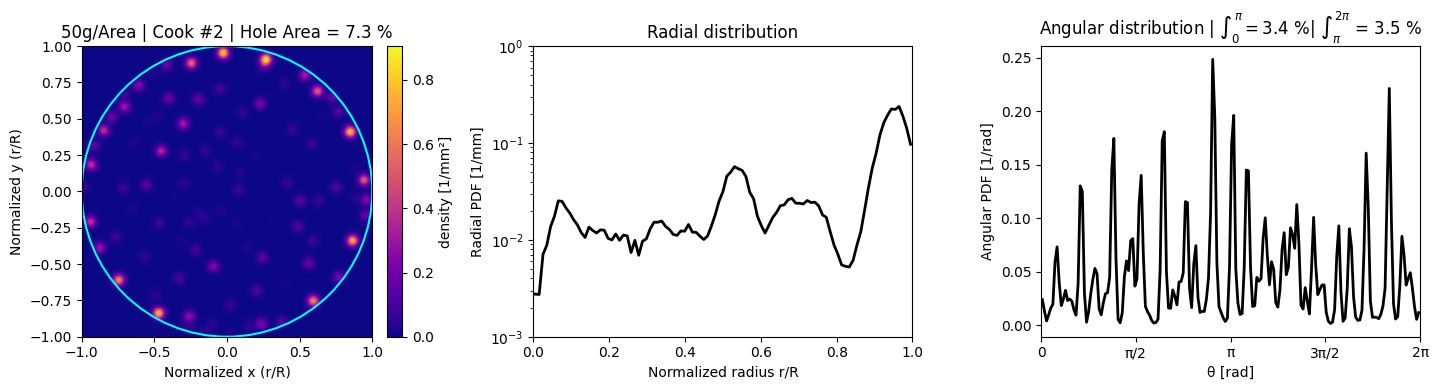

In [5]:
# === Define some groups (example) ===
group = select(["h1c2"])

groups = [
    ("50g/Area | Cook #2", group)
]

# === Example execution ===
graph_group(groups, KDE=True, RadialDist=True, AngularDist=True, SizeDist=False, Save=True)

## Pot Material

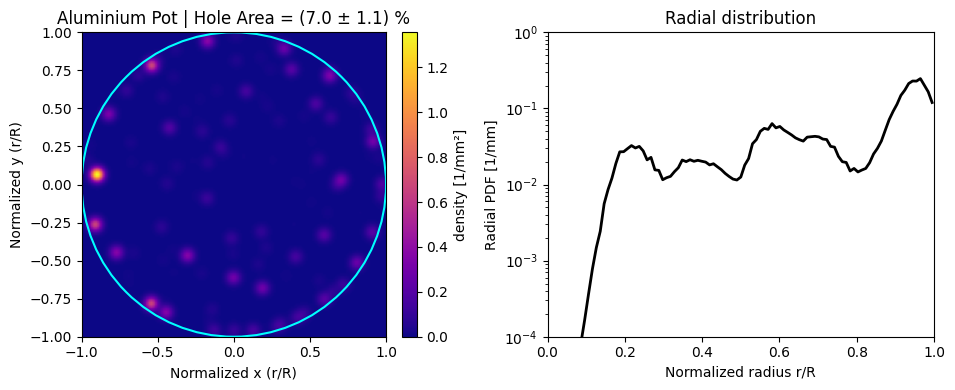

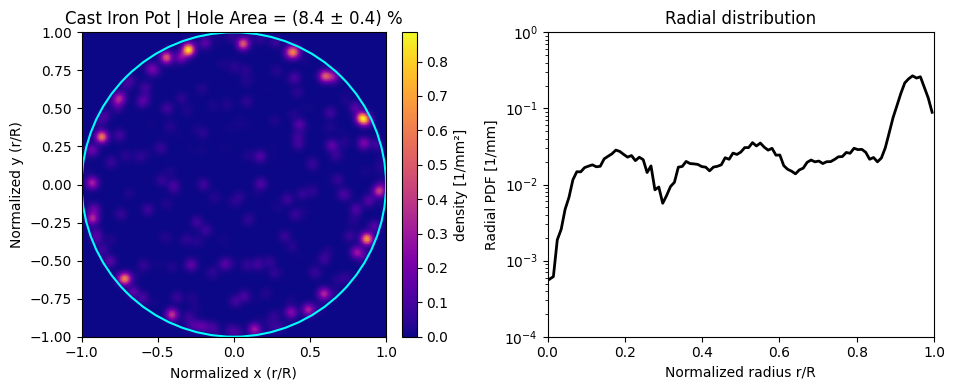

In [24]:
# === Define some groups (example) ===
group1 = select(["alc1", "alc2", "alc3"])
#group2 = select(["h2c1", "h2c2", "h2c3", "f1c1", "f1c2", "f1c3", "f2c1", "f2c2", "f2c3", "h1c1", "h1c2", "h1c3", "h3c1", "h3c2", "h3c3", "wc1", "wc2", "wc3"])
group3 = select(["h2c1", "h2c2", "h2c3"])

groups = [
    ("Aluminium Pot", group1),
    #("Aluminium Pot (Scratched)", group2),
    ("Cast Iron Pot", group3), #cambiar a todos iron
]

# === Example execution ===
graph_group(groups, KDE=True, RadialDist=True, SizeDist=False, ymin=1e-4, Save=True)

Acá no sirve mostrar todas las demás configs

## Type of Rice

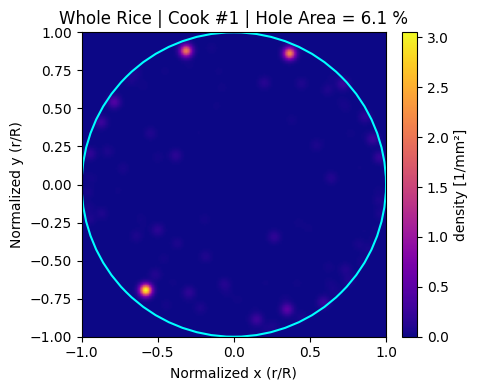

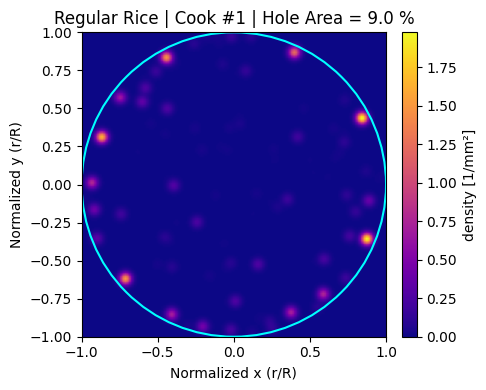

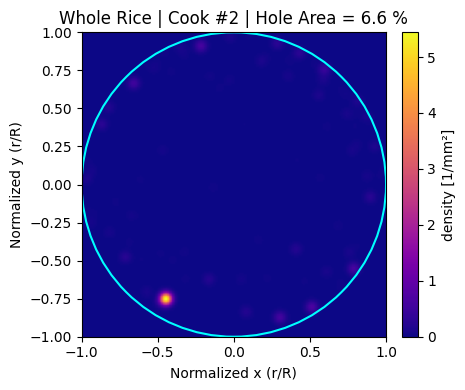

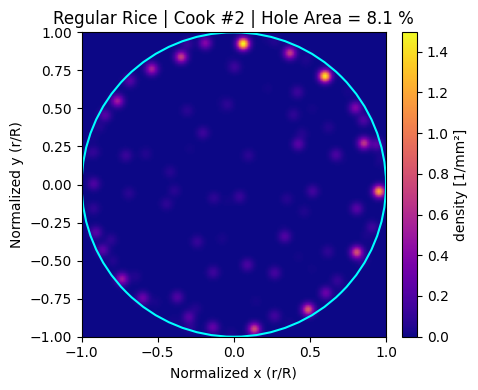

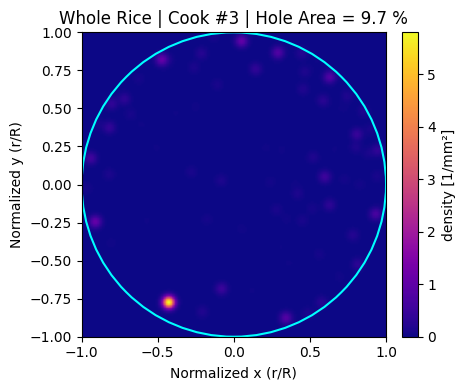

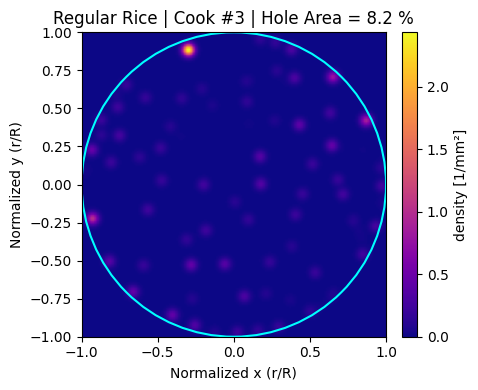

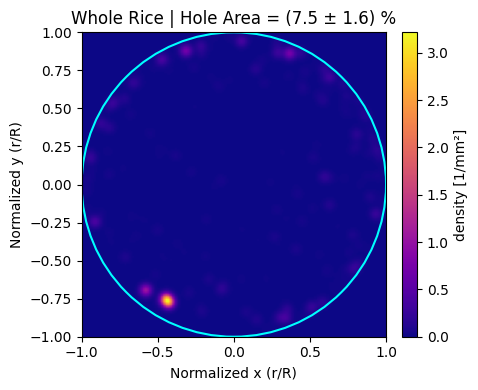

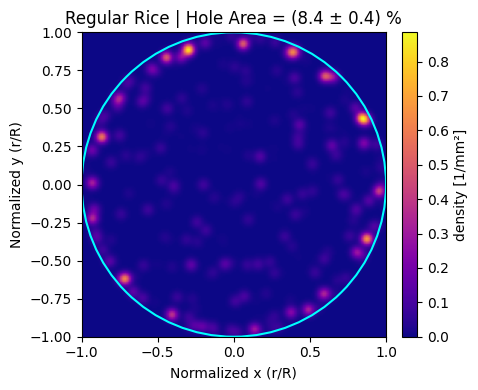

In [10]:
# === define groups ===
group1 = select(["wc1"])
group2 = select(["h2c1"])

groups = [
    ("Whole Rice | Cook #1", group1),
    ("Regular Rice | Cook #1", group2),
]
graph_group(groups, KDE=True, SizeDist=False, Save=True)

# === define groups ===
group1 = select(["wc2"])
group2 = select(["h2c2"])

groups = [
    ("Whole Rice | Cook #2", group1),
    ("Regular Rice | Cook #2", group2),
]
graph_group(groups, KDE=True, SizeDist=False, Save=True)

# === define groups ===
group1 = select(["wc3"])
group2 = select(["h2c3"])

groups = [
    ("Whole Rice | Cook #3", group1),
    ("Regular Rice | Cook #3", group2),
]
graph_group(groups, KDE=True, SizeDist=False, Save=True)

# === define groups ===
group1 = select(["wc1", "wc2", "wc3"])
group2 = select(["h2c1", "h2c2", "h2c3"])

groups = [
    ("Whole Rice", group1),
    ("Regular Rice", group2),
]
graph_group(groups, KDE=True, RadialDist=False, SizeDist=False, Save=True)

## Asymmetric Flame Configuration

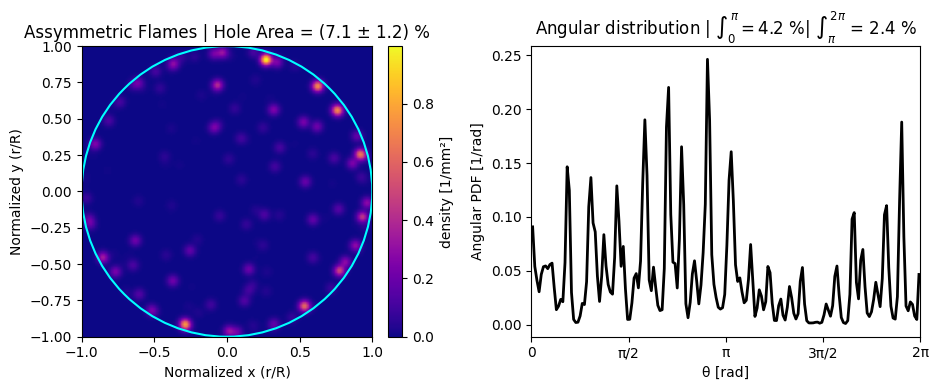

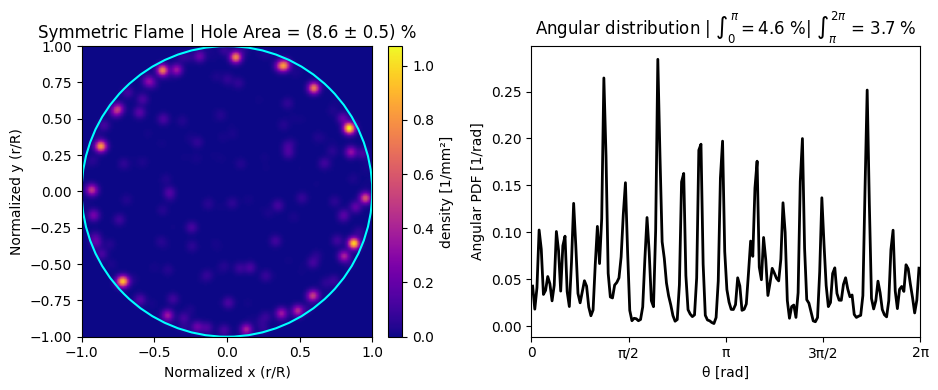

In [11]:
# === define groups ===
group1 = select(["asc2", "asc3"])
group2 = select(["h2c1", "h2c2", "h2c2"])
#group3 = select(["h2c1", "h2c2", "h2c3", 
 #                "f1c1", "f1c2", "f1c3", 
  #               "f2c1", "f2c2", "f2c3", 
   #              "h1c1", "h1c2", "h1c3", 
    #             "h3c1", "h3c2", "h3c3", 
     #            "wc1", "wc2", "wc3",
      #           "alc1", "alc2", "alc3"])


groups = [
    ("Assymmetric Flames", group1),
    ("Symmetric Flame", group2), #cambiar a todos simetricos
    #("Symmetric Flame", group3), #cambiar a todos simetricos
]
graph_group(groups, KDE=True, RadialDist=False, AngularDist=True, Save=True)

Clear dependence on flame configuration, convection cells
valley at 0.3

## Flame Intensity

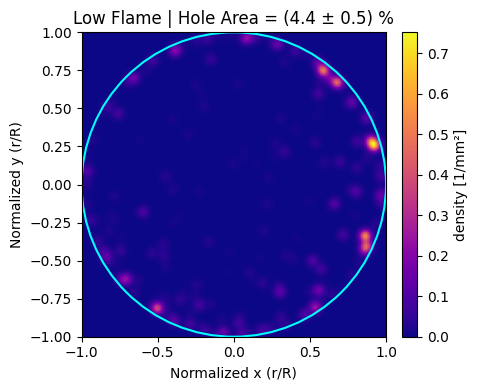

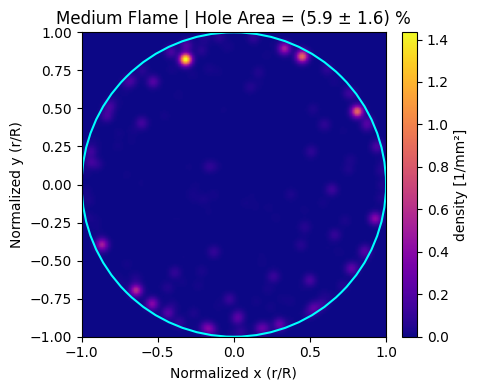

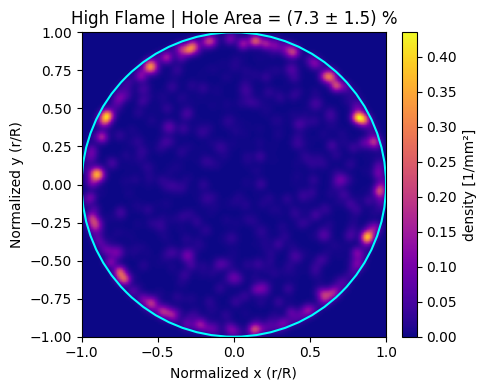

In [12]:

# === define groups ===
group1 = select(["f1c1", "f1c2", "f1c3"])
group2 = select(["f2c1", "f2c2", "f2c3"])
group3 = select(["h2c1", "h2c2", "h2c3", 
                "h1c1", "h1c2", "h1c3", 
                "h3c1", "h3c2", "h3c3",
                "alc1", "alc2", "alc3"])

groups = [
    ("Low Flame", group1),
    ("Medium Flame", group2), 
    ("High Flame", group3), 
]
graph_group(groups, KDE=True, RadialDist=False, SizeDist=False, AngularDist=False, Save=True)

Median increases with flame, more detected holes, bigger holes
Clear valley at 0.3

## Initial Mass Per Area

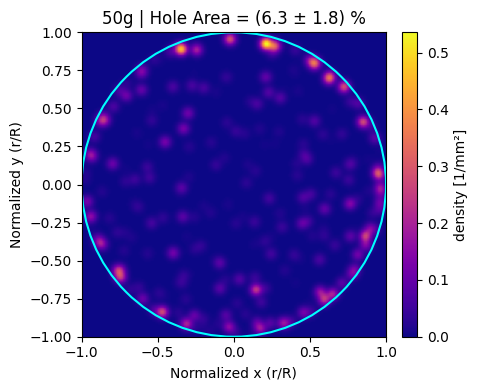

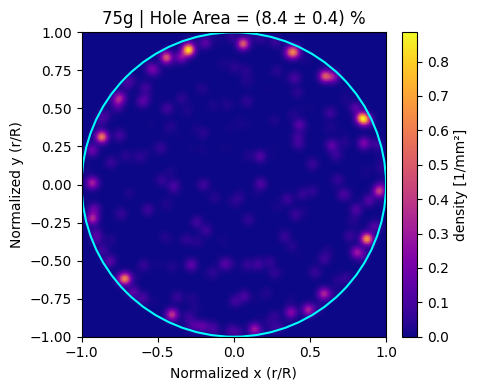

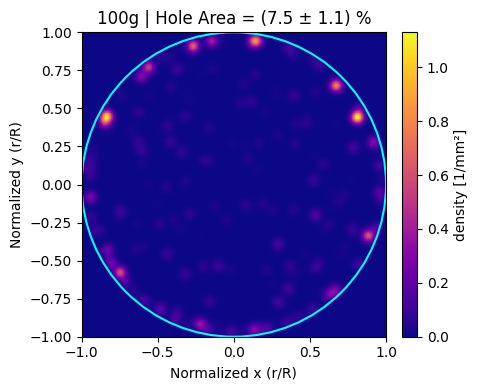

In [20]:

# === define groups ===
group1 = select(["h1c1", "h1c2", "h1c3"])
group2 = select(["h2c1", "h2c2", "h2c3"])
group3 = select(["h3c1", "h3c2", "h3c3"])


groups = [
    ("50g", group1),
    ("75g", group2), 
    ("100g", group3), 
]
graph_group(groups, KDE=True, RadialDist=False, SizeDist=False, Save=True)

1st cook: spiky radial distribution: easier for weaker bubbles to reach the top, bimodal size distribution, less hole percentage

2nd cook: more defined valleys in radial dist highest hole percentage

3rd cook: more uniform distribution, higher median hole size

## Cooking Time

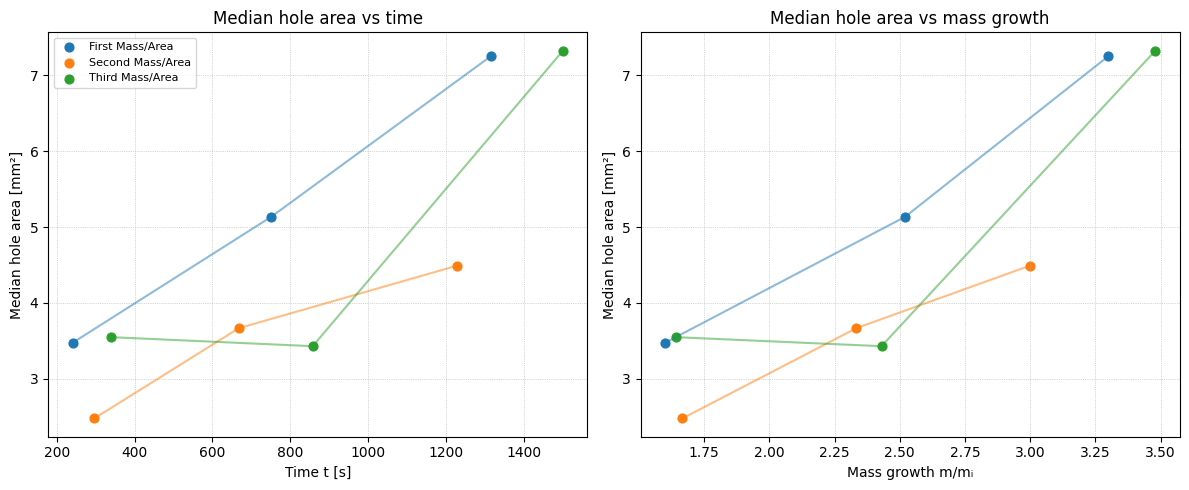

In [14]:
# Cell: plot_filtered_median_vs_time_mass.ipynb

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Build summary table from results_kde ---
rows = []
for r in results_kde:
    meta = r.get("meta", {})
    if meta is None:
        continue
    fname = r.get("fname", "")
    config = meta.get("config", fname).lower()

    # discard unwanted configs
    if config in [c["meta"]["config"].lower() for c in select([
        "f1c1","f1c2","f1c3",
        "f2c1","f2c2","f2c3",
        "asc1","asc2","asc3",
        "wc1","wc2","wc3",
        "alc1", "alc2", "alc3",
    ])]:
        continue

    series = meta.get("series", "unknown")
    t = meta.get("t", np.nan)
    mi = meta.get("mi", np.nan)
    mfinal = meta.get("m", np.nan)
    if np.isnan(mi) or np.isnan(mfinal) or mi == 0:
        mass_growth = np.nan
    else:
        mass_growth = mfinal / mi

    areas = np.asarray(r.get("areas_mm", []), dtype=float)
    if areas.size == 0:
        continue

    # log-space stats (median in log space)
    logA = np.log10(areas)
    mu = np.mean(logA)
    median_area = 10**mu

    rows.append({
        "series": series,
        "config": config,
        "t": t,
        "mass_growth": mass_growth,
        "median_area": median_area,
    })

if len(rows) == 0:
    raise RuntimeError("No data rows after filtering. Check exclusions.")

# Extract series names
series_names = sorted({r["series"] for r in rows})

# Color map
color_map = {s: plt.cm.tab10(i % 10) for i, s in enumerate(series_names)}

# Organize by series
by_series = defaultdict(list)
for r in rows:
    by_series[r["series"]].append(r)

# Sort each series by cooking time
for s in by_series:
    by_series[s] = sorted(by_series[s], key=lambda x: float(x["t"]))

# === Figure (1x2): median vs t and vs mass_growth ===
fig, (ax_a, ax_c) = plt.subplots(1, 2, figsize=(12,5))

# Panel 1: median vs t
for s, items in by_series.items():
    ts = [it["t"] for it in items]
    med = [it["median_area"] for it in items]
    ax_a.plot(ts, med, '-', color=color_map[s], alpha=0.5)
    ax_a.scatter(ts, med, color=color_map[s], s=40, label=s)

ax_a.set_xlabel("Time t [s]")
ax_a.set_ylabel("Median hole area [mm²]")
ax_a.set_title("Median hole area vs time")
ax_a.grid(True, which='both', ls=':', lw=0.5)
ax_a.legend(fontsize=8)

# Panel 2: median vs mass growth
for s, items in by_series.items():
    mg = [it["mass_growth"] for it in items]
    med = [it["median_area"] for it in items]
    ax_c.plot(mg, med, '-', color=color_map[s], alpha=0.5)
    ax_c.scatter(mg, med, color=color_map[s], s=40)

ax_c.set_xlabel("Mass growth m/mᵢ")
ax_c.set_ylabel("Median hole area [mm²]")
ax_c.set_title("Median hole area vs mass growth")
ax_c.grid(True, which='both', ls=':', lw=0.5)

plt.tight_layout()
plt.show()


Symmetric, High Flame, Regular Rice configs

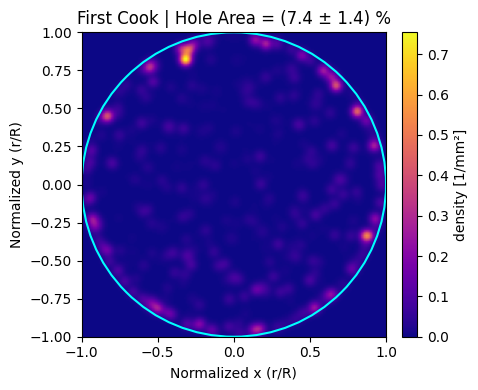

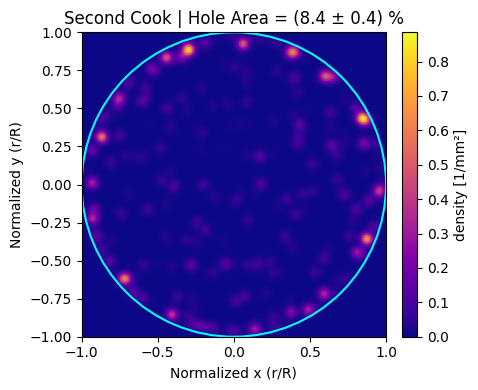

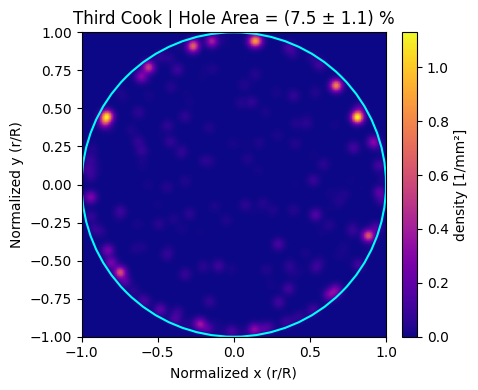

In [21]:
# === define groups ===
group1 = select(["h1c1", "h2c1", "h3c1", "f1c1", "f2c1", "alc1"])
group1 = select(["h1c2", "h2c2", "h3c2", "f1c2", "f2c2", "alc2"])
group1 = select(["h1c3", "h2c3", "h3c3", "f1c3", "f2c3", "alc3"])


groups = [
    ("First Cook", group1),
    ("Second Cook", group2), 
    ("Third Cook", group3), 
]
graph_group(groups, KDE=True, RadialDist=False, SizeDist=False, Save=True)

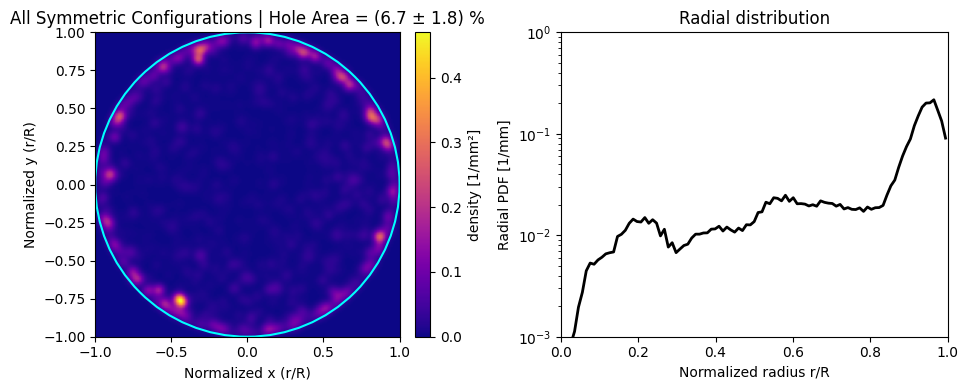

In [23]:
group = select(["h1c1", "h1c2", "h1c3",
                 "h2c1", "h2c2", "h2c3",
                 "h3c1", "h3c2", "h3c3",
                 "alc1", "alc2", "alc3",
                "wc1", "wc2", "wc3",
                "f1c1", "f1c2", "f1c3",
                "f2c1", "f2c2", "f2c3",
                ])


groups = [
    ("All Symmetric Configurations", group), 
]
graph_group(groups, KDE=True, RadialDist=True, SizeDist=False, Save=True)

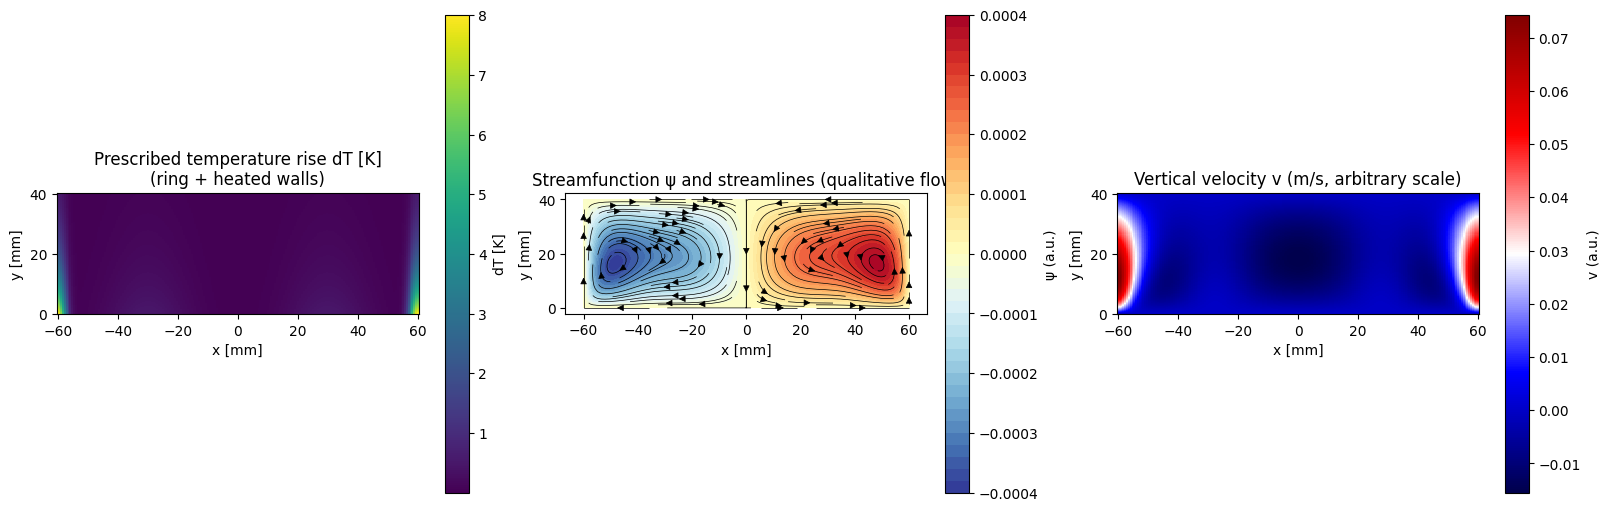

Max |psi|: 0.00038991446945941236
Max |omega|: 14.409296240691539
Max |v|: 0.07427513130594418


In [1]:
# Minimal demo: 2D Stokes-like buoyancy-driven flow from an annular (Gaussian) heat patch
# + Option A: add heated side walls (Dirichlet-like wall temperature increment) for stronger wall upflow
# Paste into a Jupyter cell and run.

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve

# -------------------------------
# Physical & geometric params
# -------------------------------
R = 0.06        # pot radius [m]
H = 0.04        # water depth [m]
r0 = 0.03       # ring radius where flame heats [m]
sigma_r = 0.01  # radial width of Gaussian ring [m]
decay_y = 0.02  # vertical decay scale of temperature from bottom [m]
dT_peak = 0.5   # peak temperature rise at the heated ring [K] (tune this)

# ----- Wall heating parameters (Option A) -----
wall_amp = 8.0        # peak temperature rise at wall [K] (try 5..20 to strengthen wall plume)
wall_sigma = 0.002    # how localized the wall heating is (m) — small means very near wall
wall_decay_y = 0.015  # vertical decay scale for wall-heating penetration (m)

# -------------------------------
# Fluid / physical constants
# -------------------------------
rho = 1000.0    # density [kg/m3]
g = 9.81        # gravity [m/s2]
beta = 2.07e-4  # thermal expansion coefficient [1/K] (water ~2e-4)
mu = 1e-3       # dynamic viscosity [Pa s]

# -------------------------------
# Numerical grid
# -------------------------------
nx, ny = 200, 120            # resolution (increase if you want smoother)
x = np.linspace(-R, R, nx)   # full diameter in x (cartesian slice)
y = np.linspace(0, H, ny)    # vertical from bottom (y=0) to free surface (y=H)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing='xy')

# -------------------------------
# Build temperature field T(x,y)
# - ring centered at radius r0 (in x direction ring at x=+/-r0)
# - we also add a heated side-wall contribution (Option A)
# -------------------------------
r_xy = np.abs(X)    # radial distance from pot centerline in this slice
# Gaussian ring in radial direction, decays in y
T0 = 20.0   # reference temperature [°C] (just offset for plotting)
dT_ring = dT_peak * np.exp(-((r_xy - r0)**2)/(2*sigma_r**2)) * np.exp(-Y/decay_y)

# Wall heating: concentrated near |x| ~ R (i.e. at the two vertical sides of the slice)
# Use a Gaussian peaked at the wall location; note (|X|-R) is ~0 at the wall
dT_wall = wall_amp * np.exp(-((np.abs(X) - R)**2)/(2*wall_sigma**2)) * np.exp(-Y/wall_decay_y)

# Total temperature anomaly above background
dT = dT_ring + dT_wall
T = T0 + dT

# Enforce top surface to be near ambient (simulate open surface cooling)
# This acts like Dirichlet at the top
T[-1, :] = T0

# -------------------------------
# Compute forcing term src = - rho*g*beta * ∂(dT)/∂x
# Laplacian(omega) = src / mu
# -------------------------------
dTdx = np.gradient(dT, dx, axis=1)
src = - rho * g * beta * dTdx   # right-hand side for vorticity Poisson

# -------------------------------
# Build 2D Laplacian operator with Dirichlet BC = 0 on boundaries
# -------------------------------
def laplacian_matrix(nx, ny, dx, dy):
    ex = np.ones(nx)
    Ax = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx)) / dx**2
    ey = np.ones(ny)
    Ay = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny)) / dy**2
    L = kron(csc_matrix(Ay), csc_matrix(identity(nx))) + kron(csc_matrix(identity(ny)), csc_matrix(Ax))
    return L.tocsc()

N = nx * ny
L = laplacian_matrix(nx, ny, dx, dy)

def dirichlet_fix_matrix(L, nx, ny):
    L = L.tolil()
    for j in range(ny):
        for i in range(nx):
            idx = j*nx + i
            if i == 0 or i == nx-1 or j == 0 or j == ny-1:
                L.rows[idx] = [idx]
                L.data[idx] = [1.0]
    return L.tocsc()

Lc = dirichlet_fix_matrix(L.copy(), nx, ny)

# -------------------------------
# Prepare RHS for vorticity Poisson: f = src/mu
# -------------------------------
f = (src / mu).ravel()

# enforce zero at boundary points
f2 = f.copy()
for j in range(ny):
    for i in range(nx):
        if i == 0 or i == nx-1 or j == 0 or j == ny-1:
            idx = j*nx + i
            f2[idx] = 0.0

# -------------------------------
# Solve for vorticity omega on grid
# -------------------------------
omega_flat = spsolve(Lc, f2)
omega = omega_flat.reshape((ny, nx))

# -------------------------------
# Solve streamfunction: Laplacian(psi) = -omega, with psi=0 on boundaries
# -------------------------------
rhs_psi = (-omega).ravel()
rhs_psi2 = rhs_psi.copy()
for j in range(ny):
    for i in range(nx):
        if i == 0 or i == nx-1 or j == 0 or j == ny-1:
            idx = j*nx + i
            rhs_psi2[idx] = 0.0

psi_flat = spsolve(Lc, rhs_psi2)
psi = psi_flat.reshape((ny, nx))

# -------------------------------
# Velocities from streamfunction: u = dψ/dy, v = -dψ/dx
# (u: horizontal, v: vertical)
# -------------------------------
dpsidy = np.gradient(psi, dy, axis=0)
dpsidx = np.gradient(psi, dx, axis=1)
u = dpsidy
v = -dpsidx

# -------------------------------
# Plot results
# -------------------------------
fig, ax = plt.subplots(1,3, figsize=(16,5), constrained_layout=True)

# 1) Temperature map (dT)
im0 = ax[0].pcolormesh(X*1000, Y*1000, dT, shading='auto')
ax[0].set_title("Prescribed temperature rise dT [K]\n(ring + heated walls)")
ax[0].set_xlabel("x [mm]"); ax[0].set_ylabel("y [mm]")
plt.colorbar(im0, ax=ax[0], label='dT [K]')

# 2) Streamfunction + streamlines
im1 = ax[1].contourf(X*1000, Y*1000, psi, 40, cmap='RdYlBu_r')
ax[1].streamplot(x*1000, y*1000, u, v, density=1.2, color='k', linewidth=0.5)
ax[1].set_title("Streamfunction ψ and streamlines (qualitative flow)")
ax[1].set_xlabel("x [mm]"); ax[1].set_ylabel("y [mm]")
plt.colorbar(im1, ax=ax[1], label='ψ (a.u.)')

# 3) Vertical velocity map (v)
im2 = ax[2].pcolormesh(X*1000, Y*1000, v, shading='auto', cmap='seismic')
ax[2].set_title("Vertical velocity v (m/s, arbitrary scale)")
ax[2].set_xlabel("x [mm]"); ax[2].set_ylabel("y [mm]")
plt.colorbar(im2, ax=ax[2], label='v (a.u.)')

for a in ax:
    a.set_aspect('equal')

plt.show()

# -------------------------------
# Quick checks / prints
# -------------------------------
print("Max |psi|:", np.max(np.abs(psi)))
print("Max |omega|:", np.max(np.abs(omega)))
print("Max |v|:", np.max(np.abs(v)))
